# **Analysis for multiple trials**

## This analysis script is well suited to analyse your data from a protocol that consists of multiple trials, with different arenas and restboxes in between.

load modules

In [1]:
%load_ext autoreload

%autoreload 2
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from spikeA.Session import *
from spikeA.Spike_train_loader import Spike_train_loader
from spikeA.Cell_group import Cell_group
from spikeA.Animal_pose import Animal_pose
from spikeA.Session import Session

set session name

In [2]:
#name="pk1615-21012022-0109"  # five different environments in two different rooms
#name="pk3865-24012022-0109"  # five different environments in two different rooms
#name="pk3865-25012022-0105" # black-white-black in 55b
#name="pk3865-27012022-0109" # five env + good coverage, good MEC signal, ADN?
#name="pk3864-31012022-0109" # first 5 OF trials for pk3864
#name="pk3864-04022022-0109" # 
#name="pk3864-05022022-0109" # 
#name="pk3864-07022022-0109" # 
#name="pk3864-09022022-0109" #
#name="pk3864-14022022-0109"
#name="pk3864-15022022-0109"
#name="pk3864-17022022-0109"
#name="pk3864-22022022-0109"
#name="pk3864-02032022-0109"
#name="pk3864-04032022-0109"
#name="pk3864-07032022-0109"
#name="pk3864-11032022-0109"
#name="pk3864-15032022-0109"
# name="pk3864-18032022-0109"

name="pk3864-28032022-0102"

Check the path

In [3]:
import os

basedir = "/adata/electro"
subject, session = name.split("-",1)
path = basedir+"/"+subject+"/"+name+"/"

fname = name.split("_")[0]

print("Path:", path)
print("Mouse:", subject) # directory = mouse subject name
print("Session:", session)
print("Name:", name, ",", fname)
print("")
print("Path:", "OK" if os.path.isdir(path) else "invalid")

Path: /adata/electro/pk3864/pk3864-28032022-0102/
Mouse: pk3864
Session: 28032022-0102
Name: pk3864-28032022-0102 , pk3864-28032022-0102

Path: OK


## Get a Session object

Check the files

In [4]:
ses = Kilosort_session(name=fname, path=path)
ses.load_parameters_from_files(ignore_params=True)  # ignore_params if kilosort has not been executed so far
print(ses)

<class 'spikeA.Session.Kilosort_session'>
name = pk3864-28032022-0102
path = /adata/electro/pk3864/pk3864-28032022-0102
subject = pk3864
session_dat_time = 2022-03-28 01:02:00
fileBase = /adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022-0102
file_names = {'par': '/adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022-0102.par', 'desen': '/adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022-0102.desen', 'desel': '/adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022-0102.desel', 'sampling_rate': '/adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022-0102.sampling_rate_dat', 'stimulation': '/adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022-0102.stimulation', 'px_per_cm': '/adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022-0102.px_per_cm', 'setup': '/adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022-0102.setup', 'environmentFamiliarity': '/adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022-0102.environmentFamiliarity', 'params':

### Trials

List all trials in that session with all information from the configuration files (setup, environment (box type: diameter, shape, color, cue card), familiarity).

In [5]:
print("all trials:\n")

for t,(tn,su,en,en_details,ef,iv) in enumerate(ses.session_trials()):
    print("#",t+1)
    print("trial:",tn)
    print("setup:",su)
    print("environment:",en)
    
    shape,diam,color,cue=en_details

    print("- Box type:",shape)
    print("- diameter:",diam)
    print("- color:",color)
    print("- cue:",cue)
    
    print("familiarity:",ef)
    print("duration:", round(iv[1]-iv[0]))
    print("")

all trials:

# 1
trial: pk3864-28032022_01
setup: 28B
environment: sqr-70_black_cue-NW
- Box type: square
- diameter: 70.0
- color: black
- cue: cue-NW
familiarity: fam
duration: 766

# 2
trial: pk3864-28032022_02
setup: 28B
environment: sqr-70_black_cue-SW
- Box type: square
- diameter: 70.0
- color: black
- cue: cue-SW
familiarity: fam
duration: 709



## Load spikes

In [6]:
stl = Spike_train_loader()
stl.load_spike_train_kilosort(ses)
print("stl.clu_ids", ",", "len =", len(stl.clu_ids))
print(stl.clu_ids)
cg = Cell_group(stl)

stl.clu_ids , len = 19
[ 5 10 11 16 17 18 20 21 25 46 47 49 50 55 65 70 71 72 73]


## Load the waveforms

Set the waveform and channel information from the session template file.

In [7]:
cg.set_info_from_session(ses, maxchannels=5)

Templates: 77 , timepoints: 82 , Channels: 64
Loaded templates-clusters-map, spikes: 769003 , clusters: 76
Init shanks: 8


For each cluster, print the active channels where the spikes were detected, and the corresponding brain area.

In [8]:
unique, counts = np.unique([ '/'.join(n.brain_area) for n in cg.neuron_list ] , return_counts=True )

for u,c in zip(unique, counts):
    print(u,":",c)

adn : 13
adn/mec : 1
mec : 5


## Create a pose file 

In [9]:
ap = Animal_pose(ses)
posefilename = ses.fileBase + ap.pose_file_extension
print("look for", posefilename)
if not os.path.exists(posefilename):
    print("load from positrack")
    extension = ap.positrack_type()
    print("use extension:",extension)
    ap.pose_from_positrack_files(ses=ses, interpolation_frequency_hz = 50, extension=extension)
    ap.save_pose_to_file() # save the file for next time
else:
    print("load from saved pose file")
    ap.load_pose_from_file()

look for /adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022-0102.pose.npy
load from positrack
use extension: positrack
Interpolation step: 400.0 samples
/adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022_01.dat
/adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022_01.positrack
Number of ttl pulses detected: 36996
Number of lines in positrack file: 36996
Saving /adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022_01.ttl_up.npy
hdRange: 360.86
degree to radian transformation
Invalid values: 9575
Valid values: 175405
Percentage of invalid values: 5.18%
****************************************************************************************
WARNING
The percentage of invalid values is very high. The quality of your data is compromised.
Solve this problem before continuing your experiments.
****************************************************************************************

/adata/electro/pk3864/pk3864-28032022-0102/pk3864-28032022_02.dat
/adata/electro/pk3864

In [10]:
ap.invalid_ratio()

0.1753294289897511

In [11]:
# find good shape automagically & crop
diameter=80.
xyrange_min,xyrange_max=ap.find_xy_range(diameter=diameter)  ###-> do this within intervals , for each trial + use min/max to find best square that covers most of the area
xmean,ymean = ap.meanloc
print("xmean,ymean",xmean,ymean)
print("xyrange_min,xyrange_max",xyrange_min,xyrange_max)

xmean,ymean 38.27689859635728 59.72689636388417
xyrange_min,xyrange_max [ 4. 18.] [84. 98.]


Plot the path of the animal to see if it was loaded correctly.

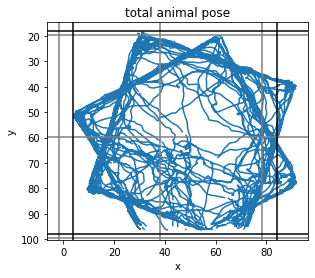

In [12]:
plt.plot(ap.pose[:,1],ap.pose[:,2])
plt.xlabel("x")
plt.ylabel("y")
#plt.scatter([xmean],[ymean], color="black", s=20)
plt.axvline(x=xmean, color="gray")
plt.axhline(y=ymean, color="gray")
plt.axvline(x=xmean+diameter/2, color="gray")
plt.axhline(y=ymean+diameter/2, color="gray")
plt.axvline(x=xmean-diameter/2, color="gray")
plt.axhline(y=ymean-diameter/2, color="gray")

plt.axvline(x=xyrange_min[0], color="black")
plt.axvline(x=xyrange_max[0], color="black")
plt.axhline(y=xyrange_min[1], color="black")
plt.axhline(y=xyrange_max[1], color="black")

plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("total animal pose")
plt.show()

Plot the occupancy map to see where the animal spent more or less time.

(The image seems mirrored since the x/y-axis for imshow is different compared to the plot function.)

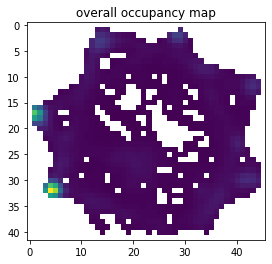

In [13]:
ap.occupancy_map_2d()
plt.imshow(ap.occupancy_map.T)
plt.title("overall occupancy map")
plt.show()

Plot the head-direction of the animal and its position a short segment.

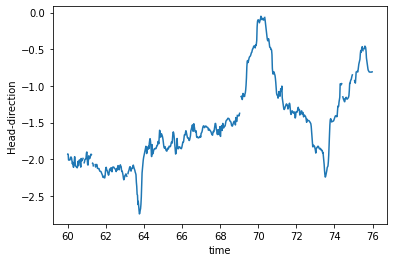

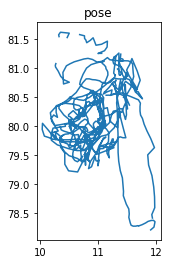

In [14]:
s=3000
e=3800

plt.plot(ap.pose[s:e,0], ap.pose[s:e,4])
plt.xlabel("time")
plt.ylabel("Head-direction")
plt.show()

plt.plot(ap.pose[s:e,1],ap.pose[s:e,2])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("pose")
plt.show()

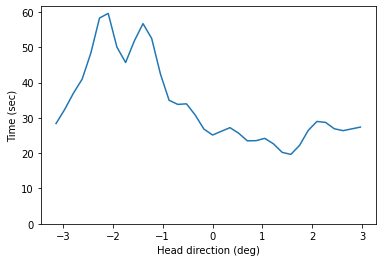

In [15]:
ap.head_direction_occupancy_histogram()
plt.plot(ap.hd_occupancy_bins[:-1],ap.hd_occupancy_histogram)
plt.ylim(0,np.max(ap.hd_occupancy_histogram)+2)
plt.ylabel("Time (sec)")
plt.xlabel("Head direction (deg)")
plt.show()

## **Summary:** Analysis for Trials

Now that we have all data from neurons and animal pose, set them together for further analysis.

Use only the `cg` or `n.spatial_properties` from now on.

In [16]:
print("number of trials:", ses.n_trials)
trials_in_environment = [ i for i,en in enumerate(ses.desen) if not en.startswith("rb") ]
trials_in_environment_number = len(trials_in_environment)
print("without restbox:", trials_in_environment_number)
session_trials = ses.session_trials()

number of trials: 2
without restbox: 2


Now we need to set the SpatialProperties object of each Neuron objects of the CellGroup.
Then we can get information score for each neuron from a firing rate map without smoothing.
We recalculate the maps with smoothing for display purposes.

In [17]:
cg.set_spatial_properties(ap)

Show a summary of all trials in that session with lots of information (skip restbox)

In [18]:
import matplotlib.patches as patches

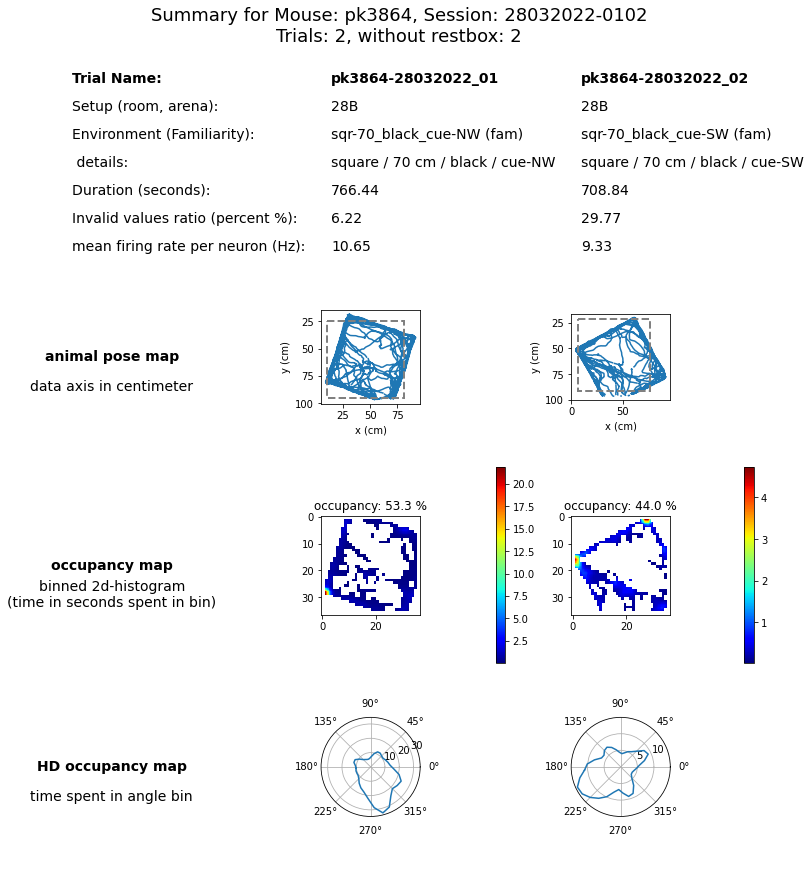

In [19]:
rows = 4
cols = trials_in_environment_number+1

fig, ax = plt.subplots(nrows=rows, ncols=cols, constrained_layout=True, figsize=(3.5*cols,3*rows))

plt.suptitle("Summary for Mouse: "+subject+", Session: "+session + "\n" +"Trials: "+str(ses.n_trials)+", without restbox: "+str(trials_in_environment_number) ,fontsize=18)
#plt.title()

# use this subplot only as grid for text
#ax[0,0].set_title("summary")
ax[0,0].axis("off")
ax[0,0].set_xlim([0, 10])
ax[0,0].set_ylim([0, 7])
ax[0,0].invert_yaxis()

ax[0,0].text(1.0,1.0, "Trial Name:", weight="bold", fontsize=14, verticalalignment="center")
for y,txt in enumerate(["Setup (room, arena)", "Environment (Familiarity)", " details", "Duration (seconds)", "Invalid values ratio (percent %)", "mean firing rate per neuron (Hz)"]):
    ax[0,0].text(1.0, 2+y, txt+":", fontsize=14, verticalalignment="center")

rows_description = [ ["animal pose map","data axis in centimeter"] , ["occupancy map", "binned 2d-histogram\n(time in seconds spent in bin)"], ["HD occupancy map", "time spent in angle bin"] ] 
for r,label in zip(np.arange(1,rows) , rows_description):
    #ax[r,0].set_title("occupancy map")
    ax[r,0].axis("off")
    ax[r,0].set_xlim([-1, 1])
    ax[r,0].set_ylim([-1, 1])
    ax[r,0].invert_yaxis()
    ax[r,0].text(0,0, label[0], weight="bold", fontsize=14, horizontalalignment="center", verticalalignment="center")
    ax[r,0].text(0,0.3, label[1], fontsize=14, horizontalalignment="center", verticalalignment="center")


i=1
for t,(tn,su,en,(shape,diam,color,cue),ef,iv) in enumerate(session_trials):
    # skip restbox
    if not t in trials_in_environment:
        continue
        
    # first row = desciption
    # use this subplot only as grid for text
    #ax[0,i].set_title(tn)
    ax[0,i].axis("off")
    ax[0,i].set_xlim([0, 10])
    ax[0,i].set_ylim([0, 7])
    ax[0,i].invert_yaxis()
    #ax[0,i].scatter([1],[1])
    

    ## restrict to trial = set appropriate interval
    ap.set_intervals(iv)
    cg.set_spatial_properties(ap) # apply these to all neurons
    # print(cg.mean_firing_rate_per_neuron()) # this can be now calculated for the specific trial
    # print(cg.neuron_list[0].spike_train.st)
    
    ax[0,i].text(1.0,1.0, tn, weight="bold", fontsize=14, verticalalignment="center")
    for y,txt in enumerate([su, en+" ("+ef+")", ' / '.join([shape,str(round(diam))+' cm',str(color),str(cue)]), np.round(iv[1]-iv[0],2) , np.round(100.*ap.invalid_ratio(),2) , np.round(cg.mean_firing_rate_per_neuron(),2) ]):
        ax[0,i].text(1.0, 2+y, txt, fontsize=14, verticalalignment="center")
    
    
    
    ## draw animal's pose, and automagically detected square
    ax[1,i].plot(ap.pose[:,1],ap.pose[:,2])
    
    ax[1,i].set_aspect('equal', adjustable='box')
    #ax[1,i].axis('scaled')
    #ax[1,i].autoscale()
    
    xyrange_min,xyrange_max = ap.find_xy_range(diameter = diam)
    # print("meanloc",ap.meanloc)
    # print("poserect",ap.poserect)

    # draw the Rectangle (pose xy_range), and add it as patch to the Axes
    rect = patches.Rectangle((xyrange_min[0], xyrange_min[1]), diam, diam, linewidth=2, edgecolor='gray', ls="dashed", fill=False, facecolor='none', zorder=4)
    ax[1,i].add_patch(rect)
    
    # draw the cue card
    cue = cue.split('-')
    if len(cue)>1:
        cue = cue[1]
    else:
        cue = cue[0]
    
    cuelen = diam/5.
    cuewidth = 3.
    
    cardinal_direction = {
        'N':((xyrange_min[0]+diam/2.-cuelen/2., xyrange_min[1]-cuewidth/2.) , cuelen, cuewidth),
        'S':((xyrange_min[0]+diam/2.-cuelen/2., xyrange_max[1]-cuewidth/2.) , cuelen, cuewidth),
        'W':((xyrange_min[0]-cuewidth/2., xyrange_min[1]+diam/2.-cuelen/2.) , cuewidth, cuelen),
        'E':((xyrange_max[0]-cuewidth/2., xyrange_min[1]+diam/2.-cuelen/2.) , cuewidth, cuelen)
    }
    cue_coords = cardinal_direction.get(cue, False)
    if cue_coords:
        (x0,y0),width,height = cue_coords
        rect = patches.Rectangle((x0,y0), width, height, linewidth=2, edgecolor='black', facecolor='black', fill=True, zorder=5)
        ax[1,i].add_patch(rect)
    
    # y is increasing south, like in imshow
    ax[1,i].invert_yaxis()
    
    #ax[1,i].axis('off')
    ax[1,i].set_xlabel("x (cm)")
    ax[1,i].set_ylabel("y (cm)")
    
    
    ## occupancy map
    ap.invalid_outside_spatial_area(shape=shape, radius=diam/2., length=diam, center=np.mean([xyrange_min,xyrange_max],axis=0))
    ap.occupancy_map_2d() 
    im = ax[2,i].imshow(ap.occupancy_map.T, cmap='jet')#, origin="lower")
    #ax[2,i].plot([1,2,3],[5,5,7])
    c = fig.colorbar(im,ax=ax[2,i], pad=-0.3)
    #im.set_clim(0, 0.5)
    #maxocc=[None]*trials_in_environment_number , collect to normalize all together with same colorbar
    # print(np.nanmax(ap.occupancy_map))
    occupancy = ap.occupancy(arena=shape)
    ax[2,i].set_title("occupancy: {:.1f} %".format(occupancy*100))
    
    ## HD occupancy map
    ap.head_direction_occupancy_histogram()  # calculate HD occ map
    angles = ap.mid_point_from_edges(ap.hd_occupancy_bins) # get mid angles from histogram edges
    #ax[3,i].set_ylim(0,np.max(ap.hd_occupancy_histogram)*1.2)
    # make polar plot (radius = time spent in that HD bin)
    ax[3,i].axis('off')
    ax2 = fig.add_subplot(rows, cols, cols*3+i+1, polar=True)
    #ax2.plot(angles, ap.hd_occupancy_histogram)
    ax2.plot(np.append(angles,angles[0]), np.append(ap.hd_occupancy_histogram,ap.hd_occupancy_histogram[0]))
    ax2.grid(True)
    
    i+=1
    
#plt.subplots_adjust(wspace=0.1, hspace=0.3, top=.85)
#fig.set_constrained_layout_pads(w_pad=4./72., h_pad=4./72., hspace=0./72., wspace=0./72.)

plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'_summary.pdf')
plt.show()

## Analysis for all neurons

In [20]:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_nested.html
import matplotlib.backends.backend_pdf
from tqdm import tqdm
import matplotlib.gridspec as gridspec

In [21]:
# https://stackoverflow.com/a/33505522

from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [22]:
hd_cells_all = []   # list: is HD cell (bool)
grid_cells_all = [] # list: is grid cell (bool)

hd_angles_all = [] # list: mean direction angle

firing_rate_maps_all = [] # list: firing rate maps
grid_rotations_all = [] # list: autocorrelation hexagon rotation (derived from firing rate map -> autocorrelation map -> hexagon)


  0%|                                                    | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_3573/1964801147.py:60: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim((0,np.max(n.spike_train.st_autocorrelation_histogram[0])*1.1))
/tmp/ipykernel_3573/1964801147.py:69: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim((0,np.max(n.spike_train.st_autocorrelation_histogram[0])*1.1))


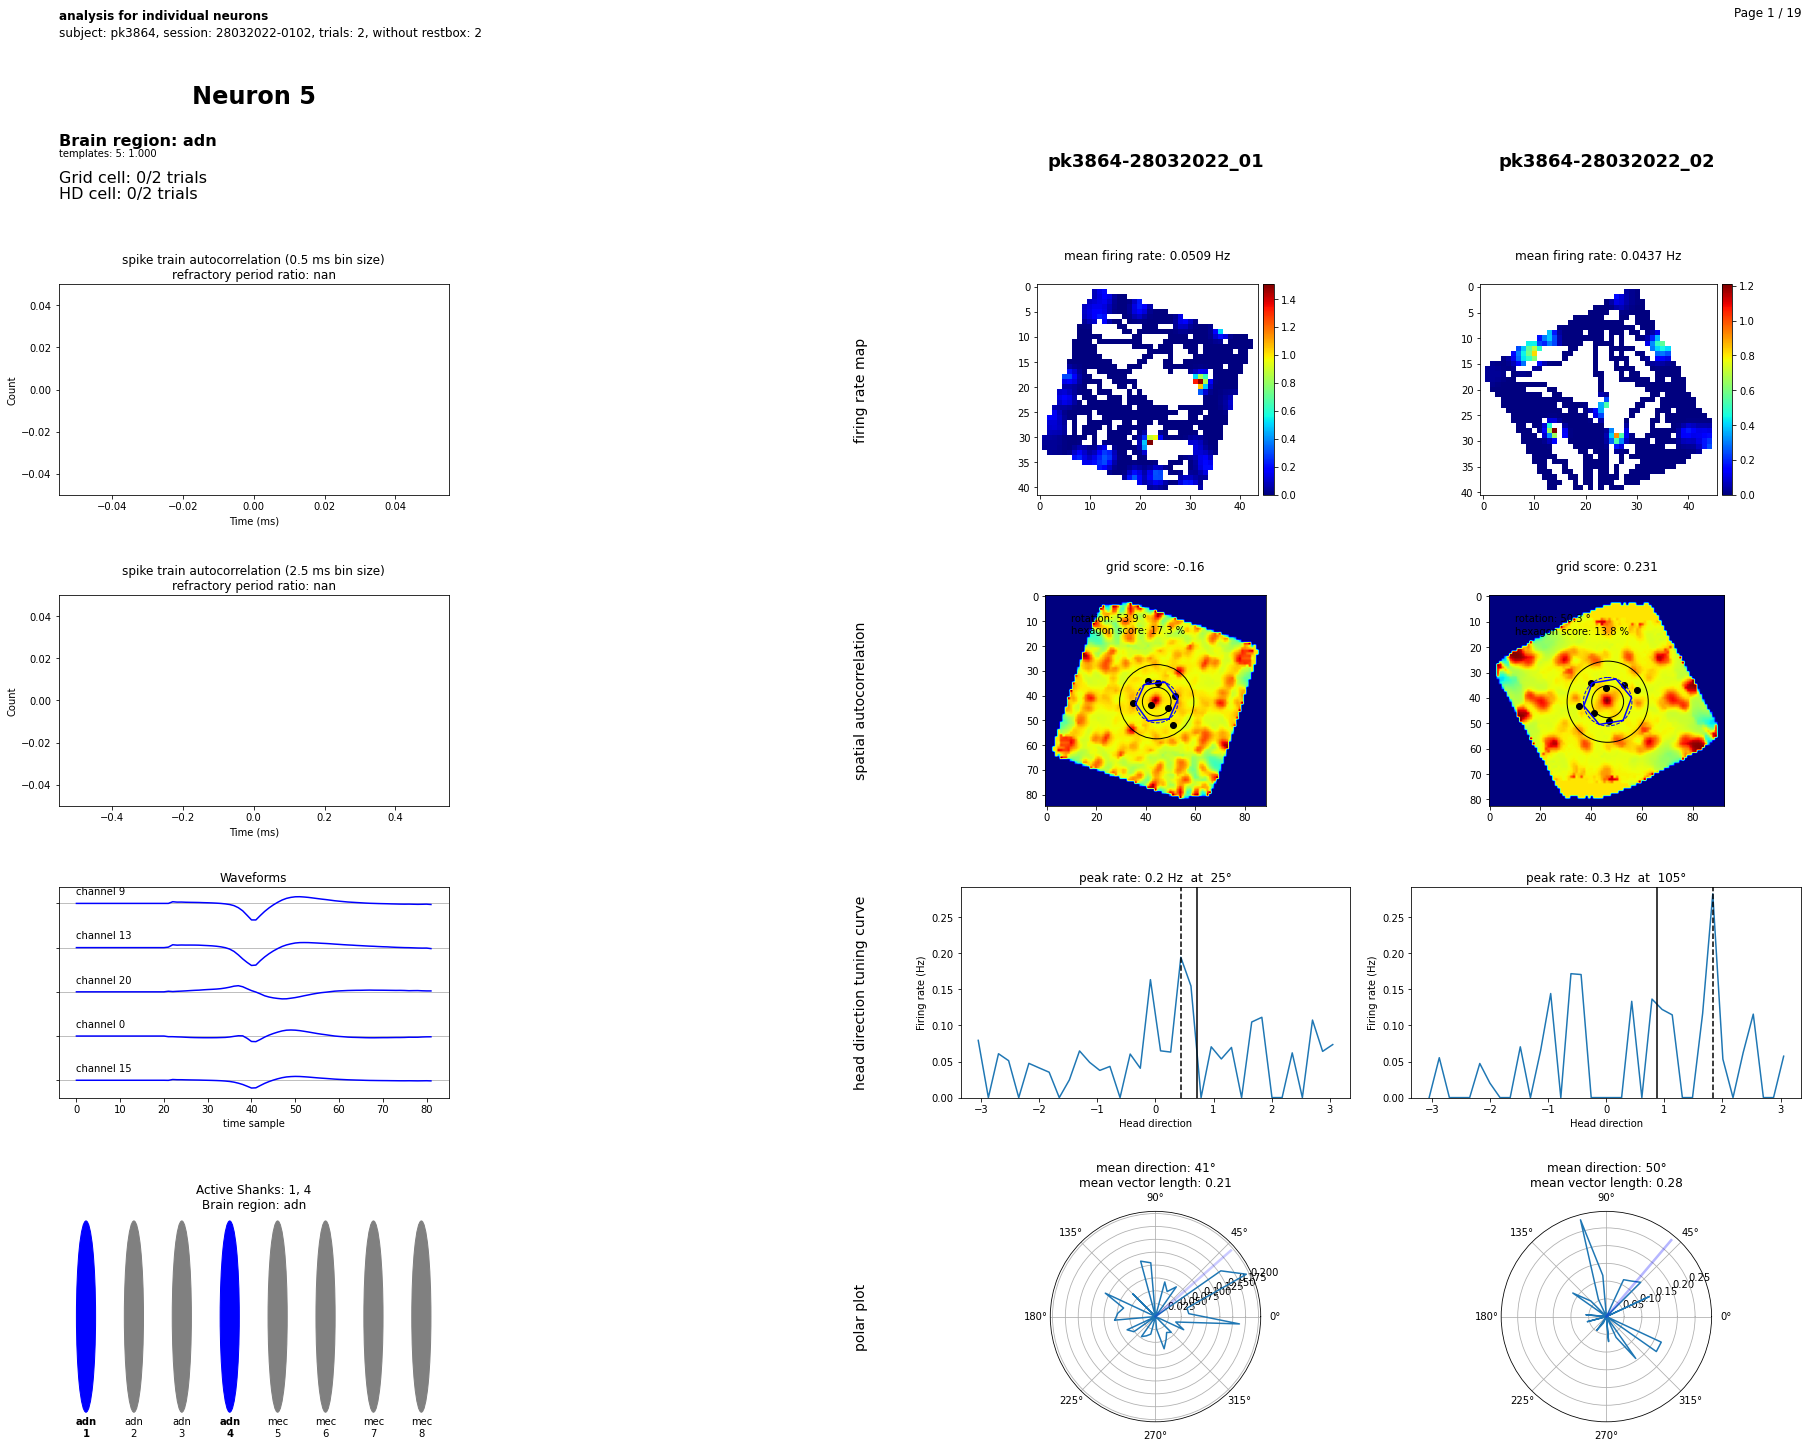

  5%|██▎                                         | 1/19 [00:06<01:57,  6.55s/it]

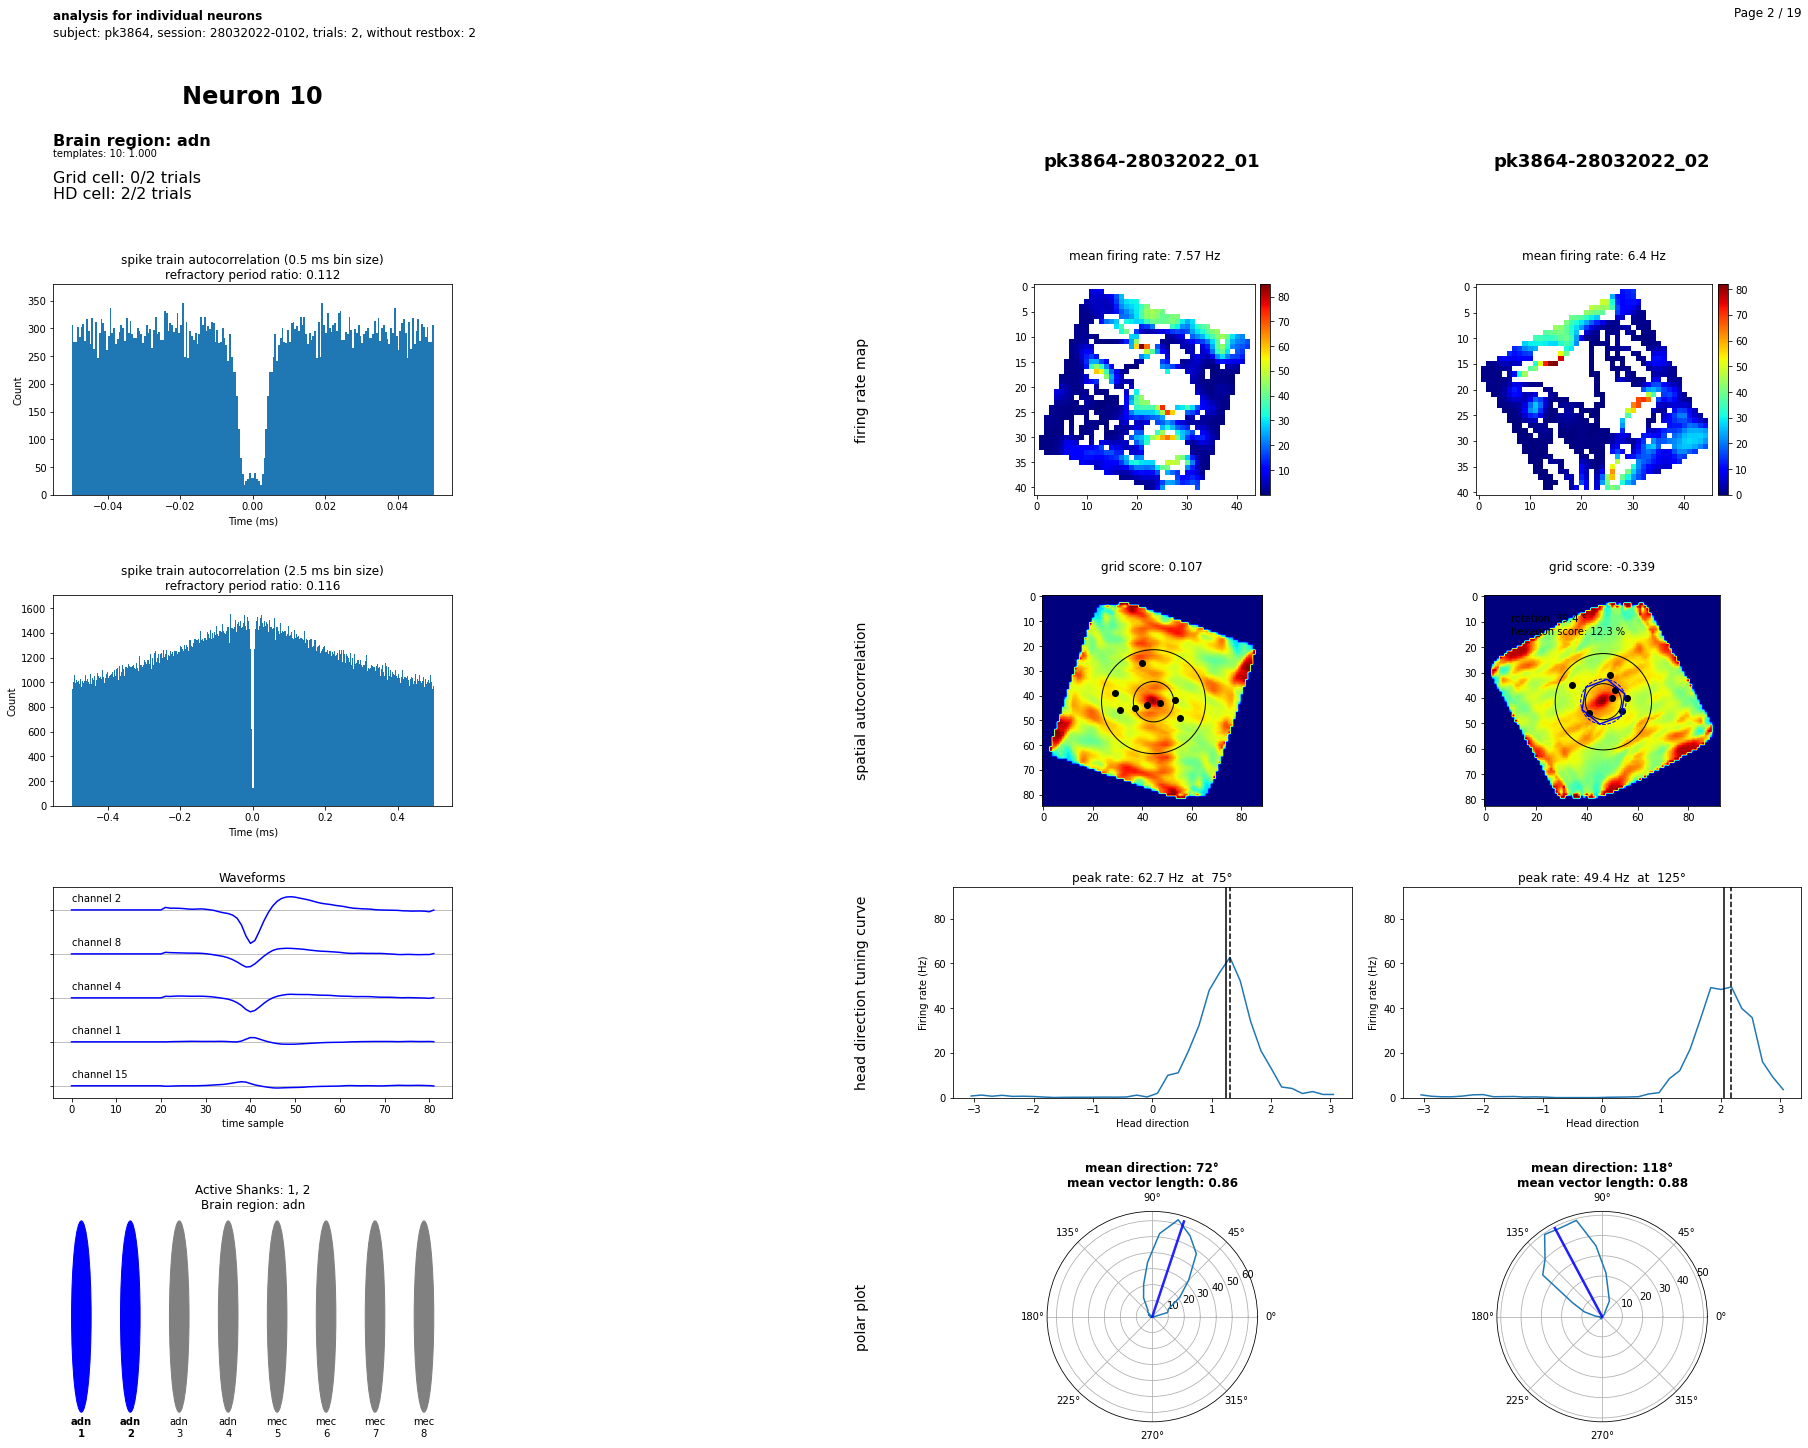

 11%|████▋                                       | 2/19 [00:12<01:46,  6.29s/it]

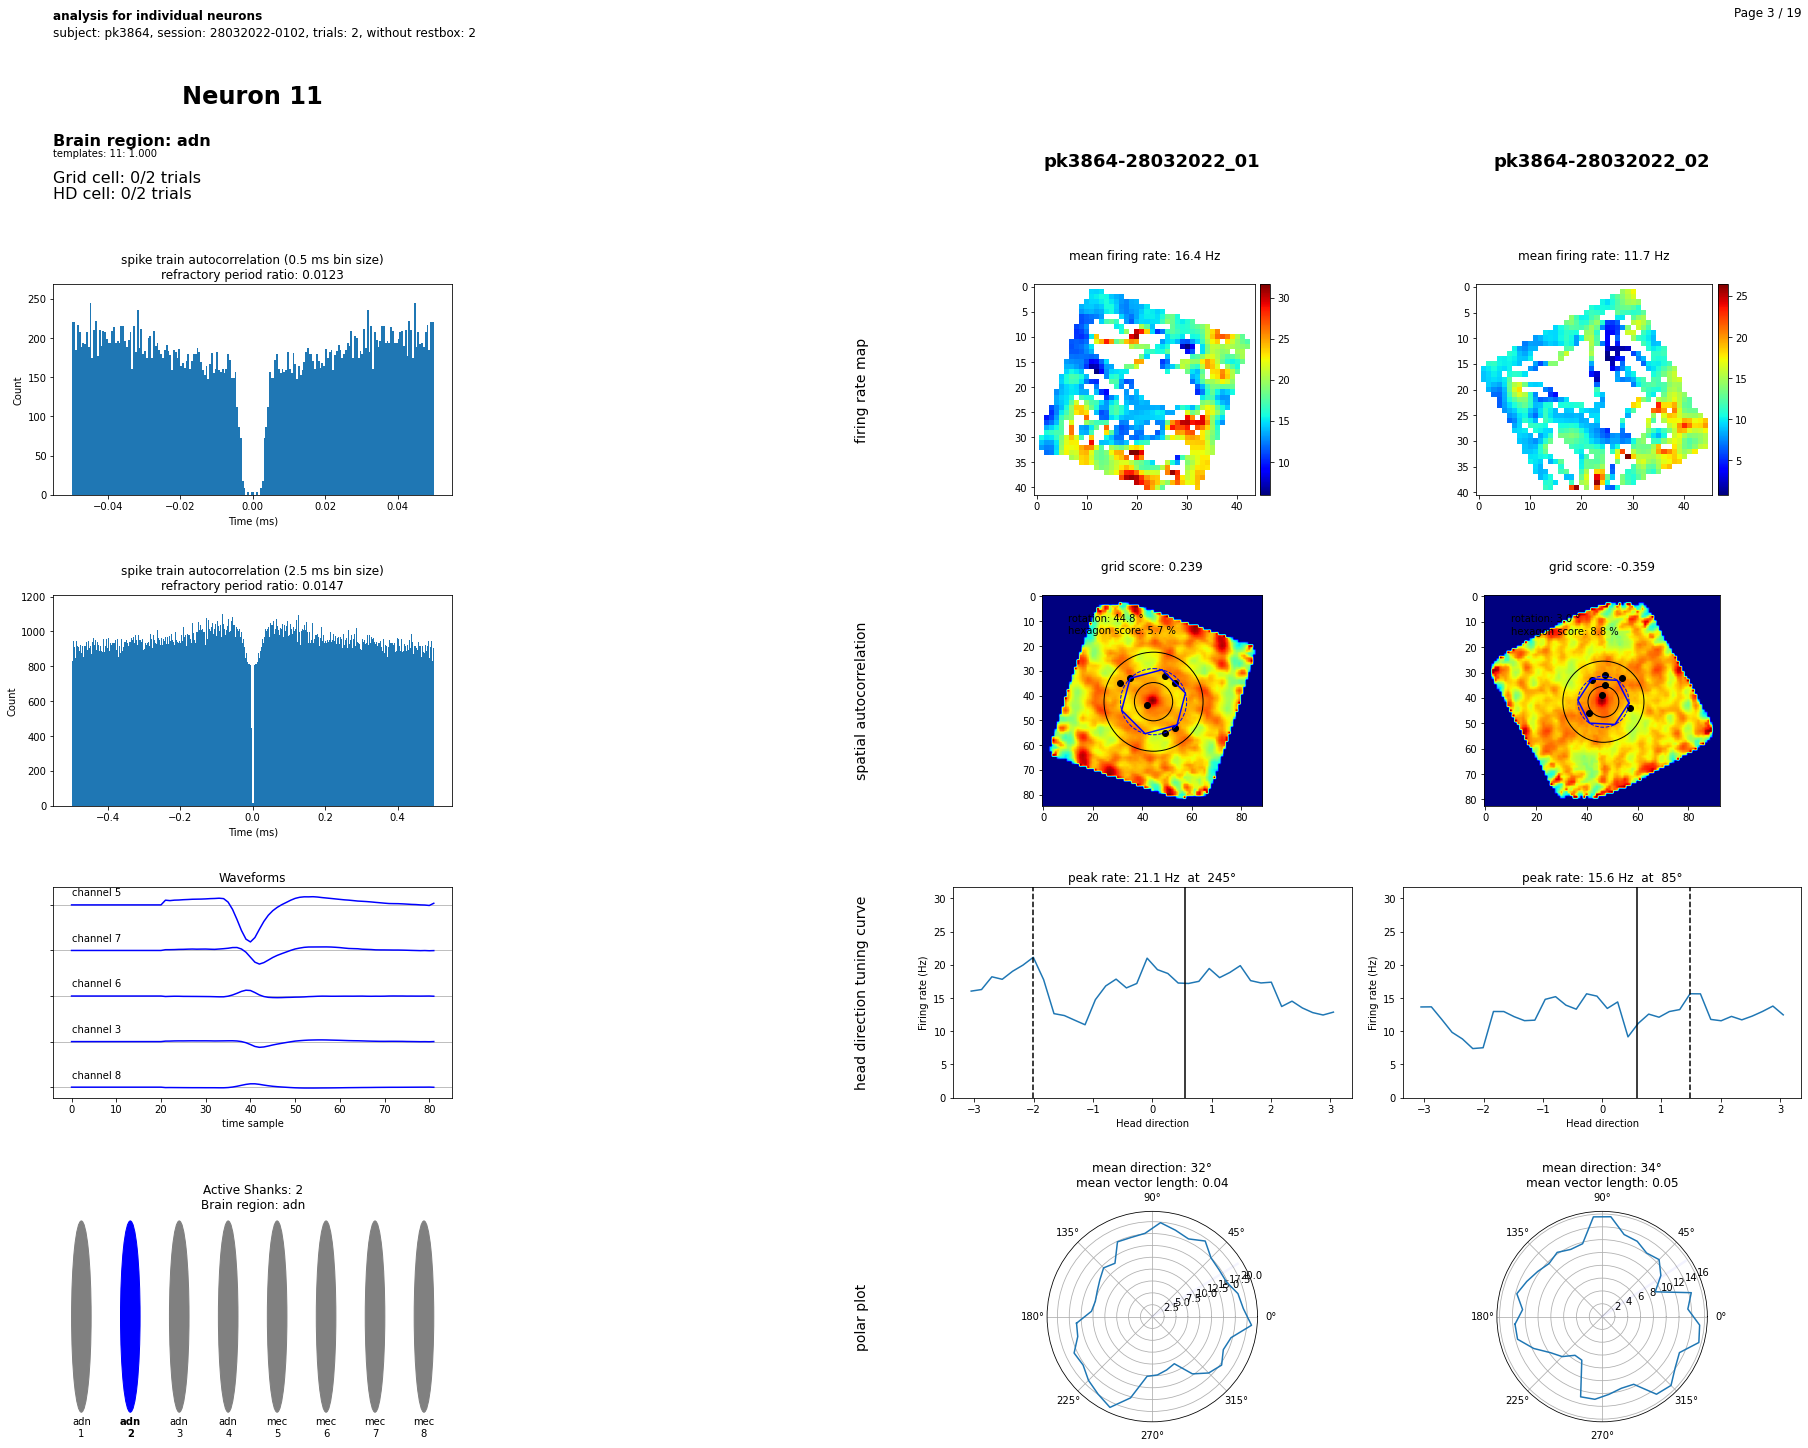

 16%|██████▉                                     | 3/19 [00:18<01:40,  6.29s/it]

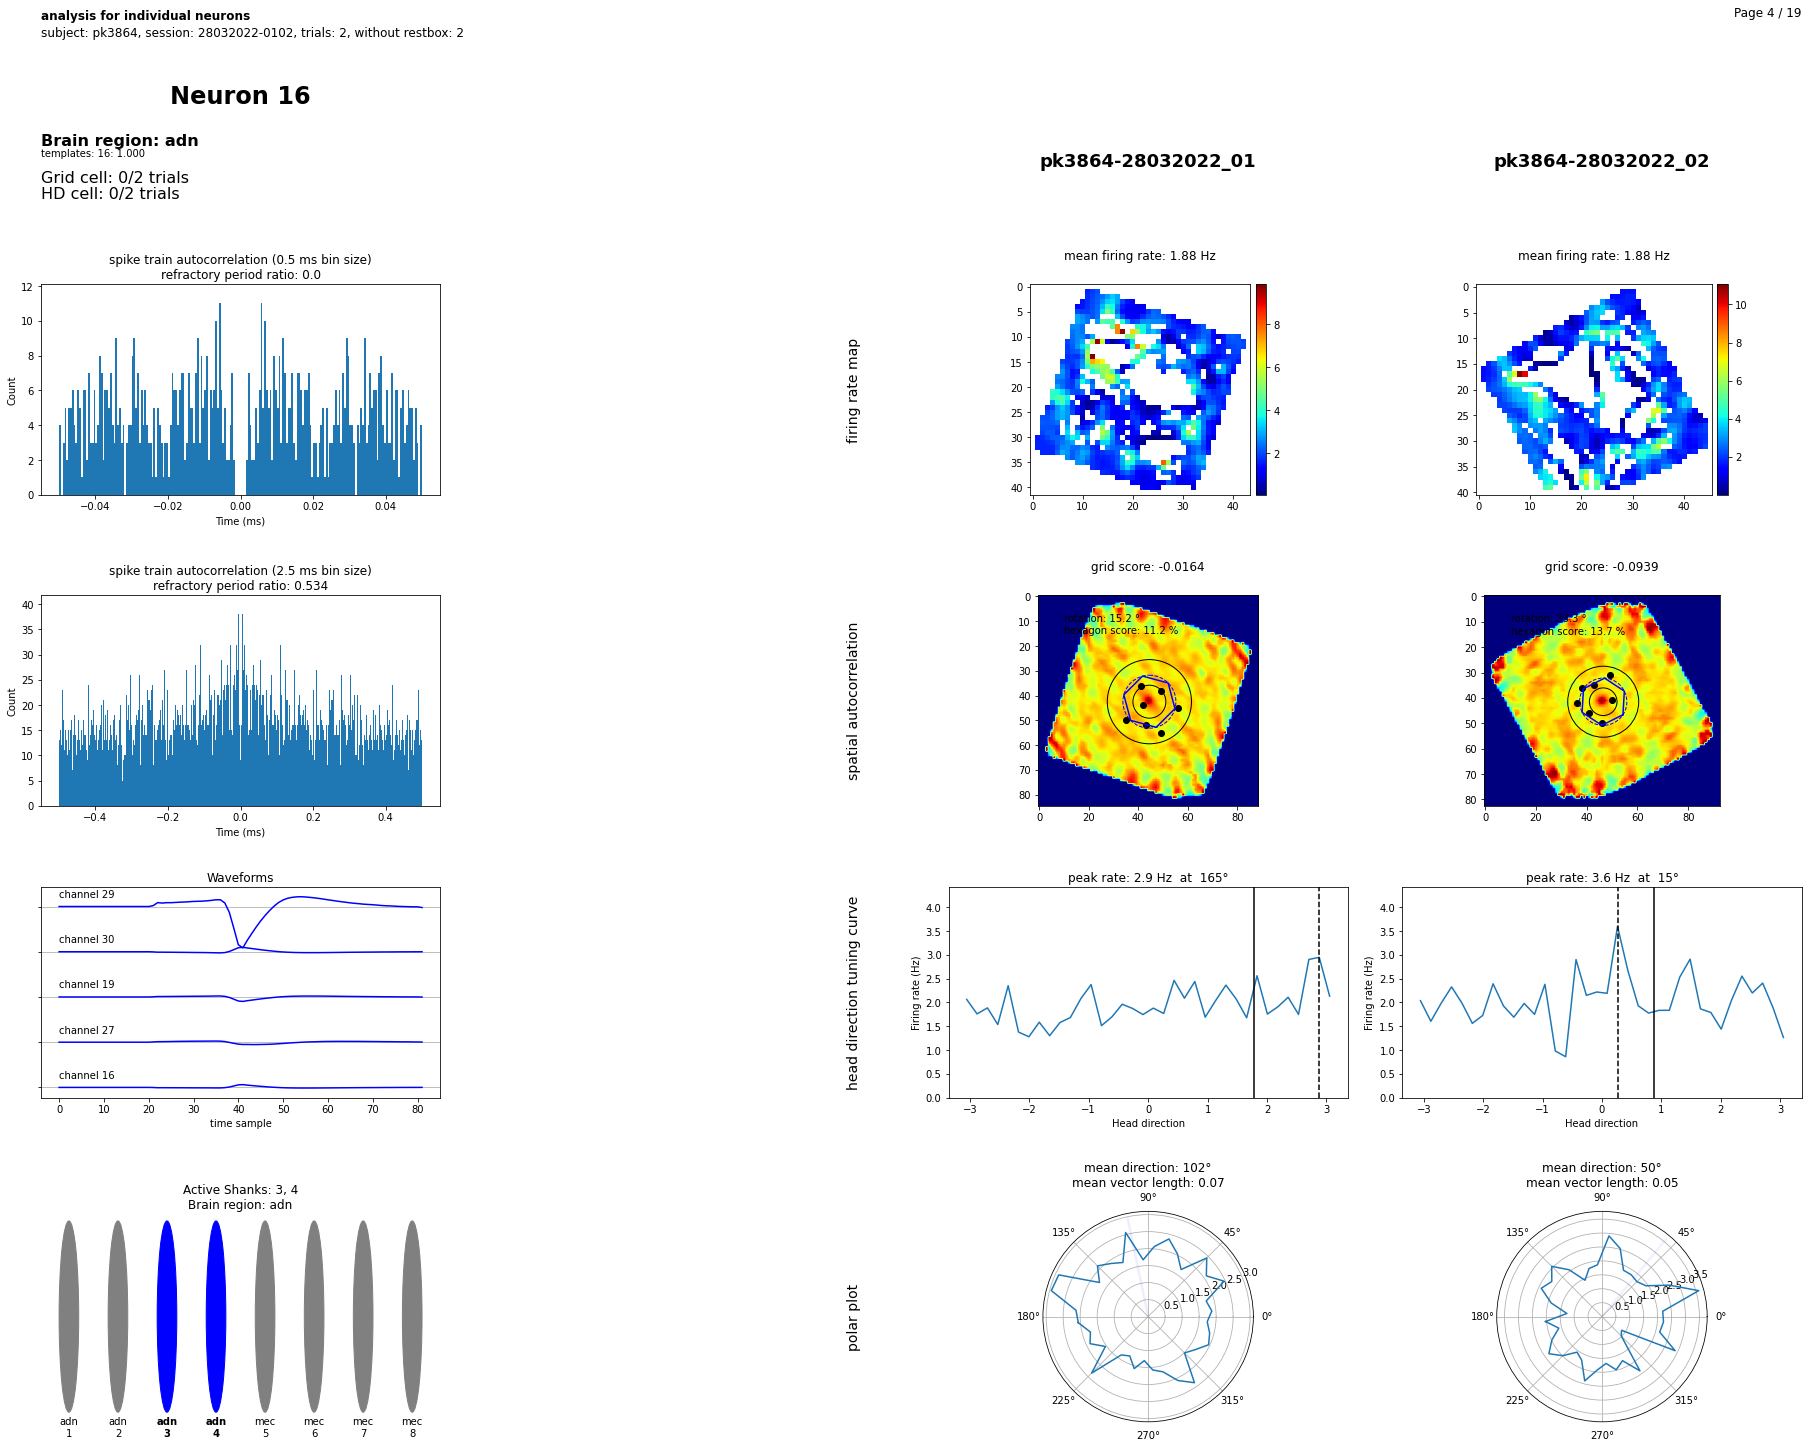

 21%|█████████▎                                  | 4/19 [00:25<01:34,  6.30s/it]

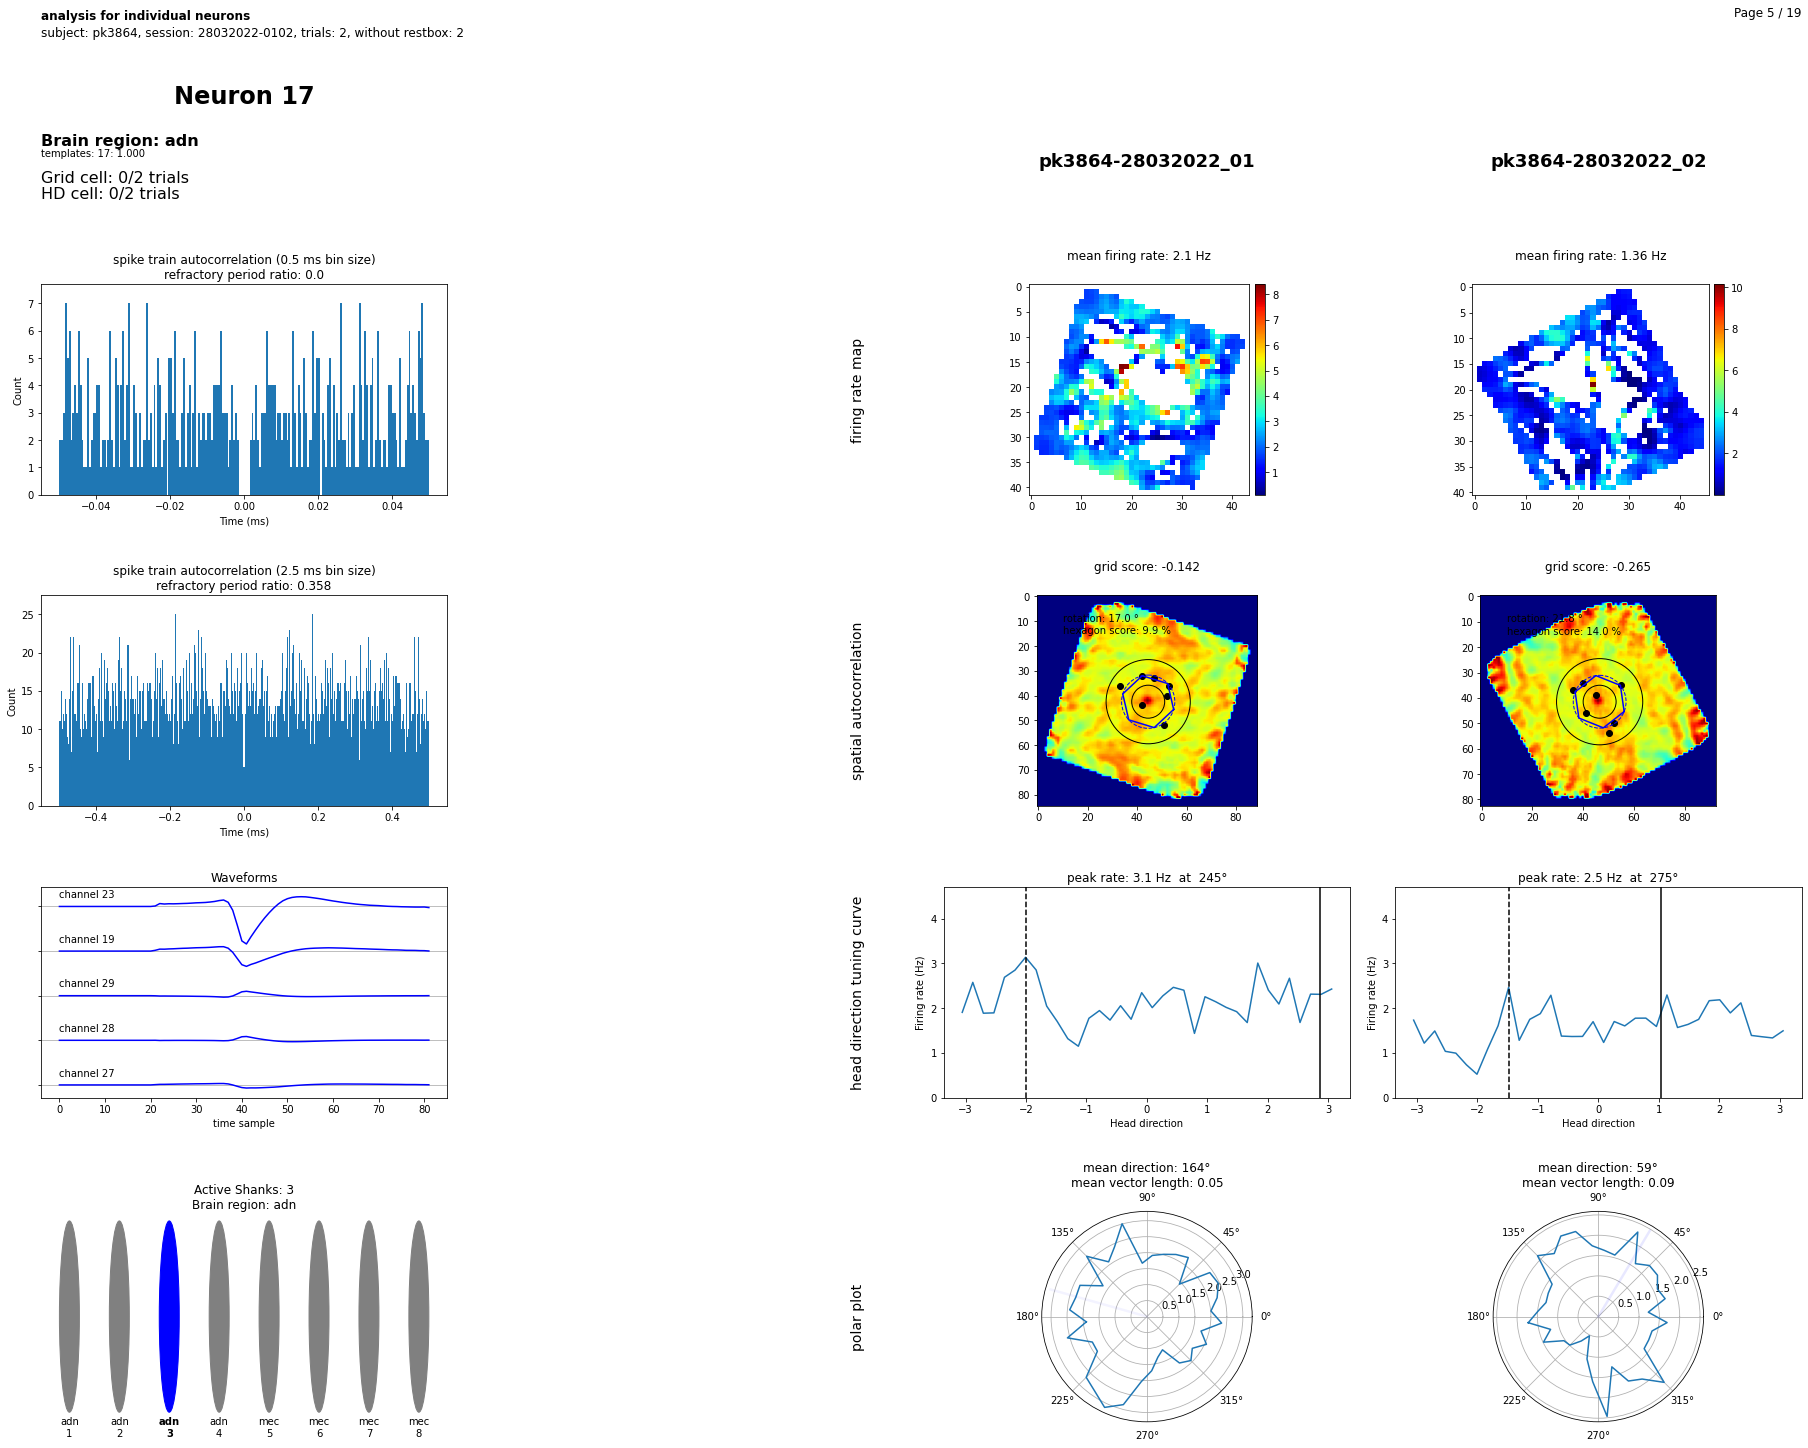

 26%|███████████▌                                | 5/19 [00:31<01:27,  6.27s/it]

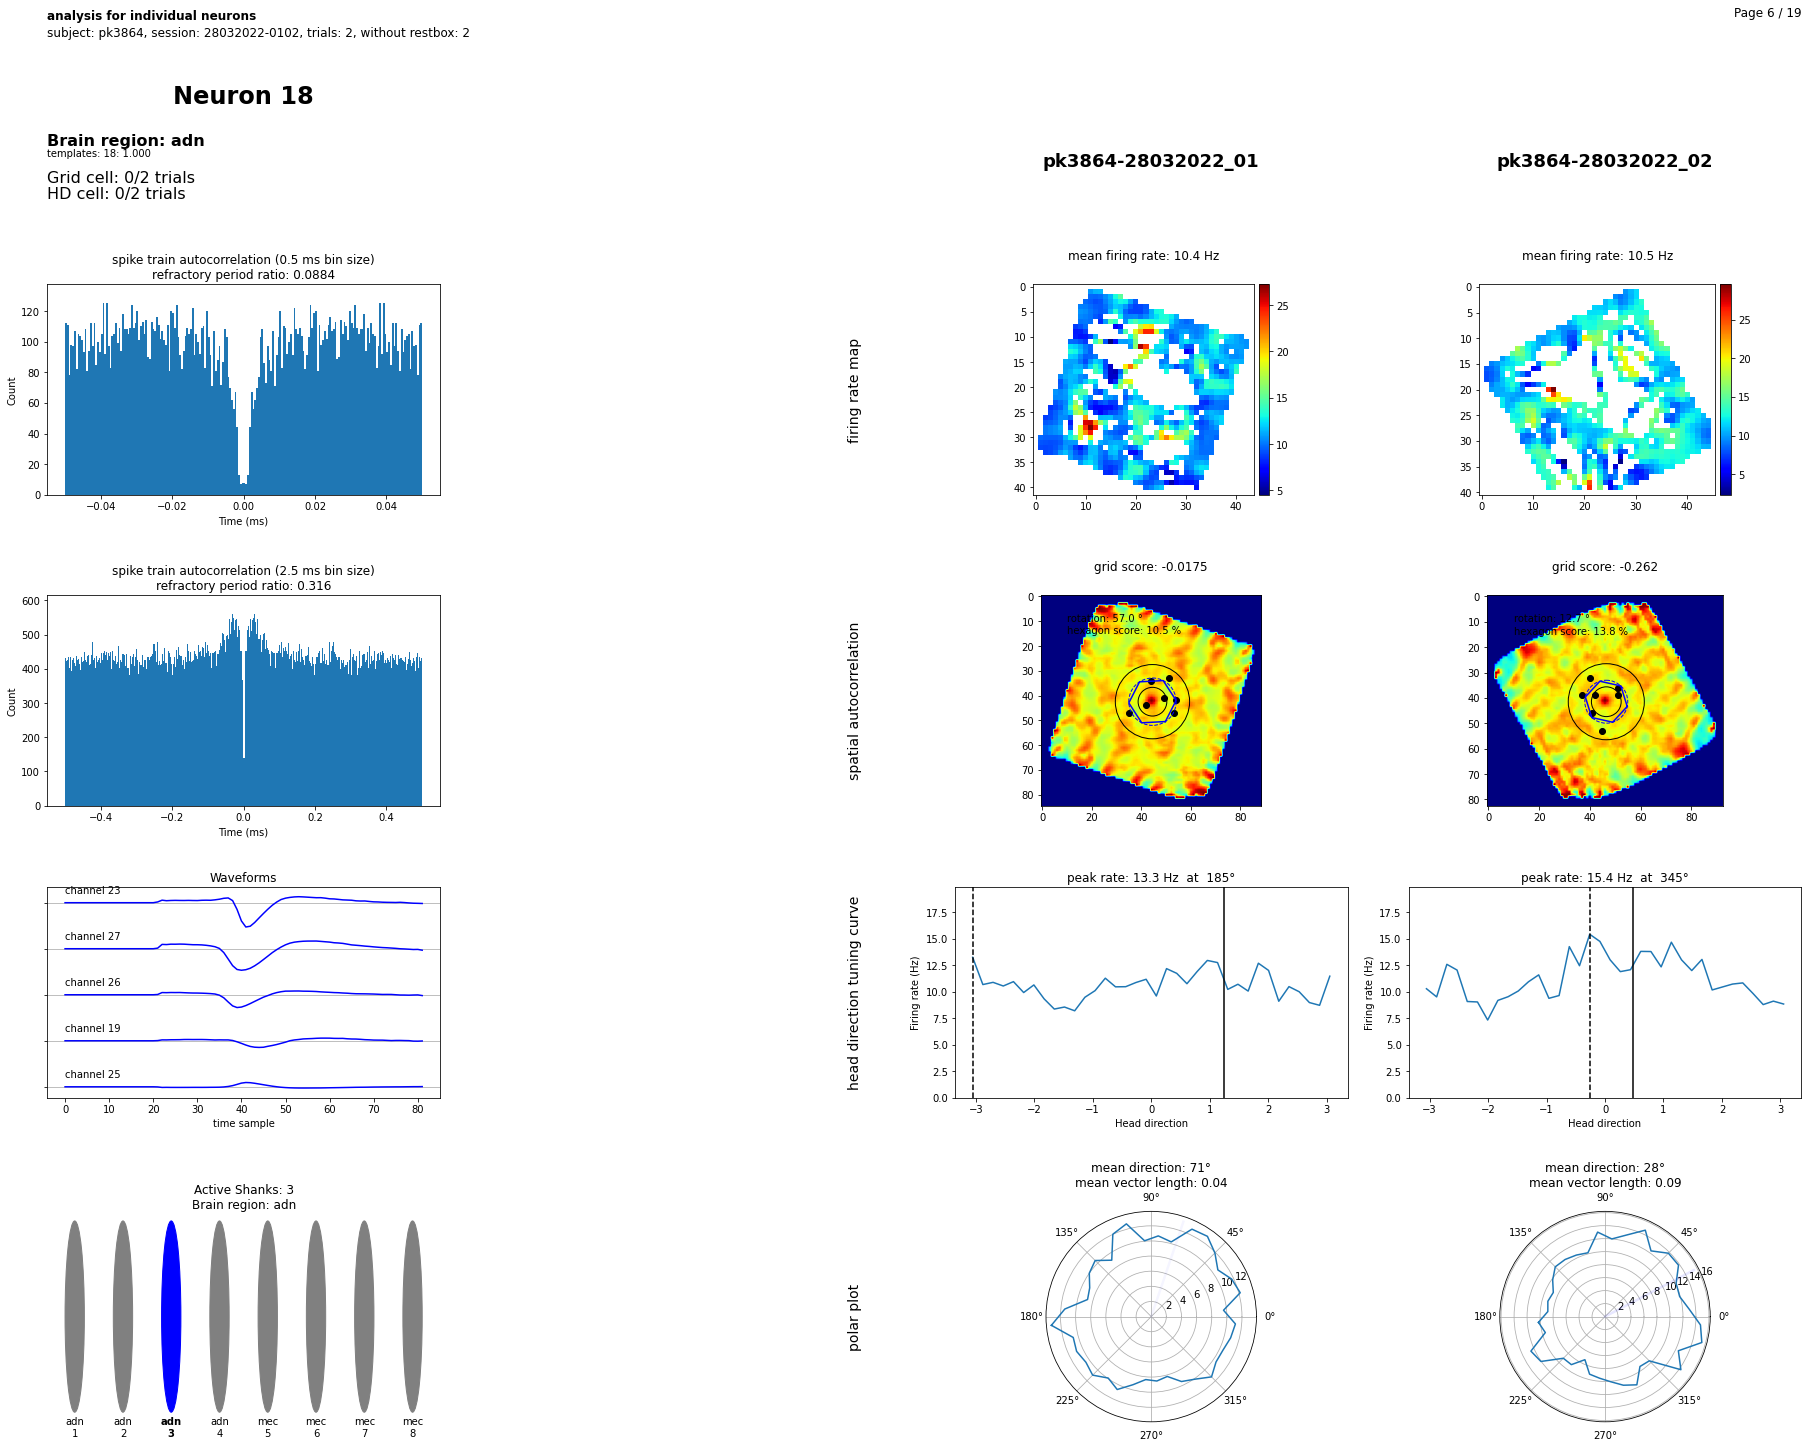

 32%|█████████████▉                              | 6/19 [00:38<01:22,  6.37s/it]

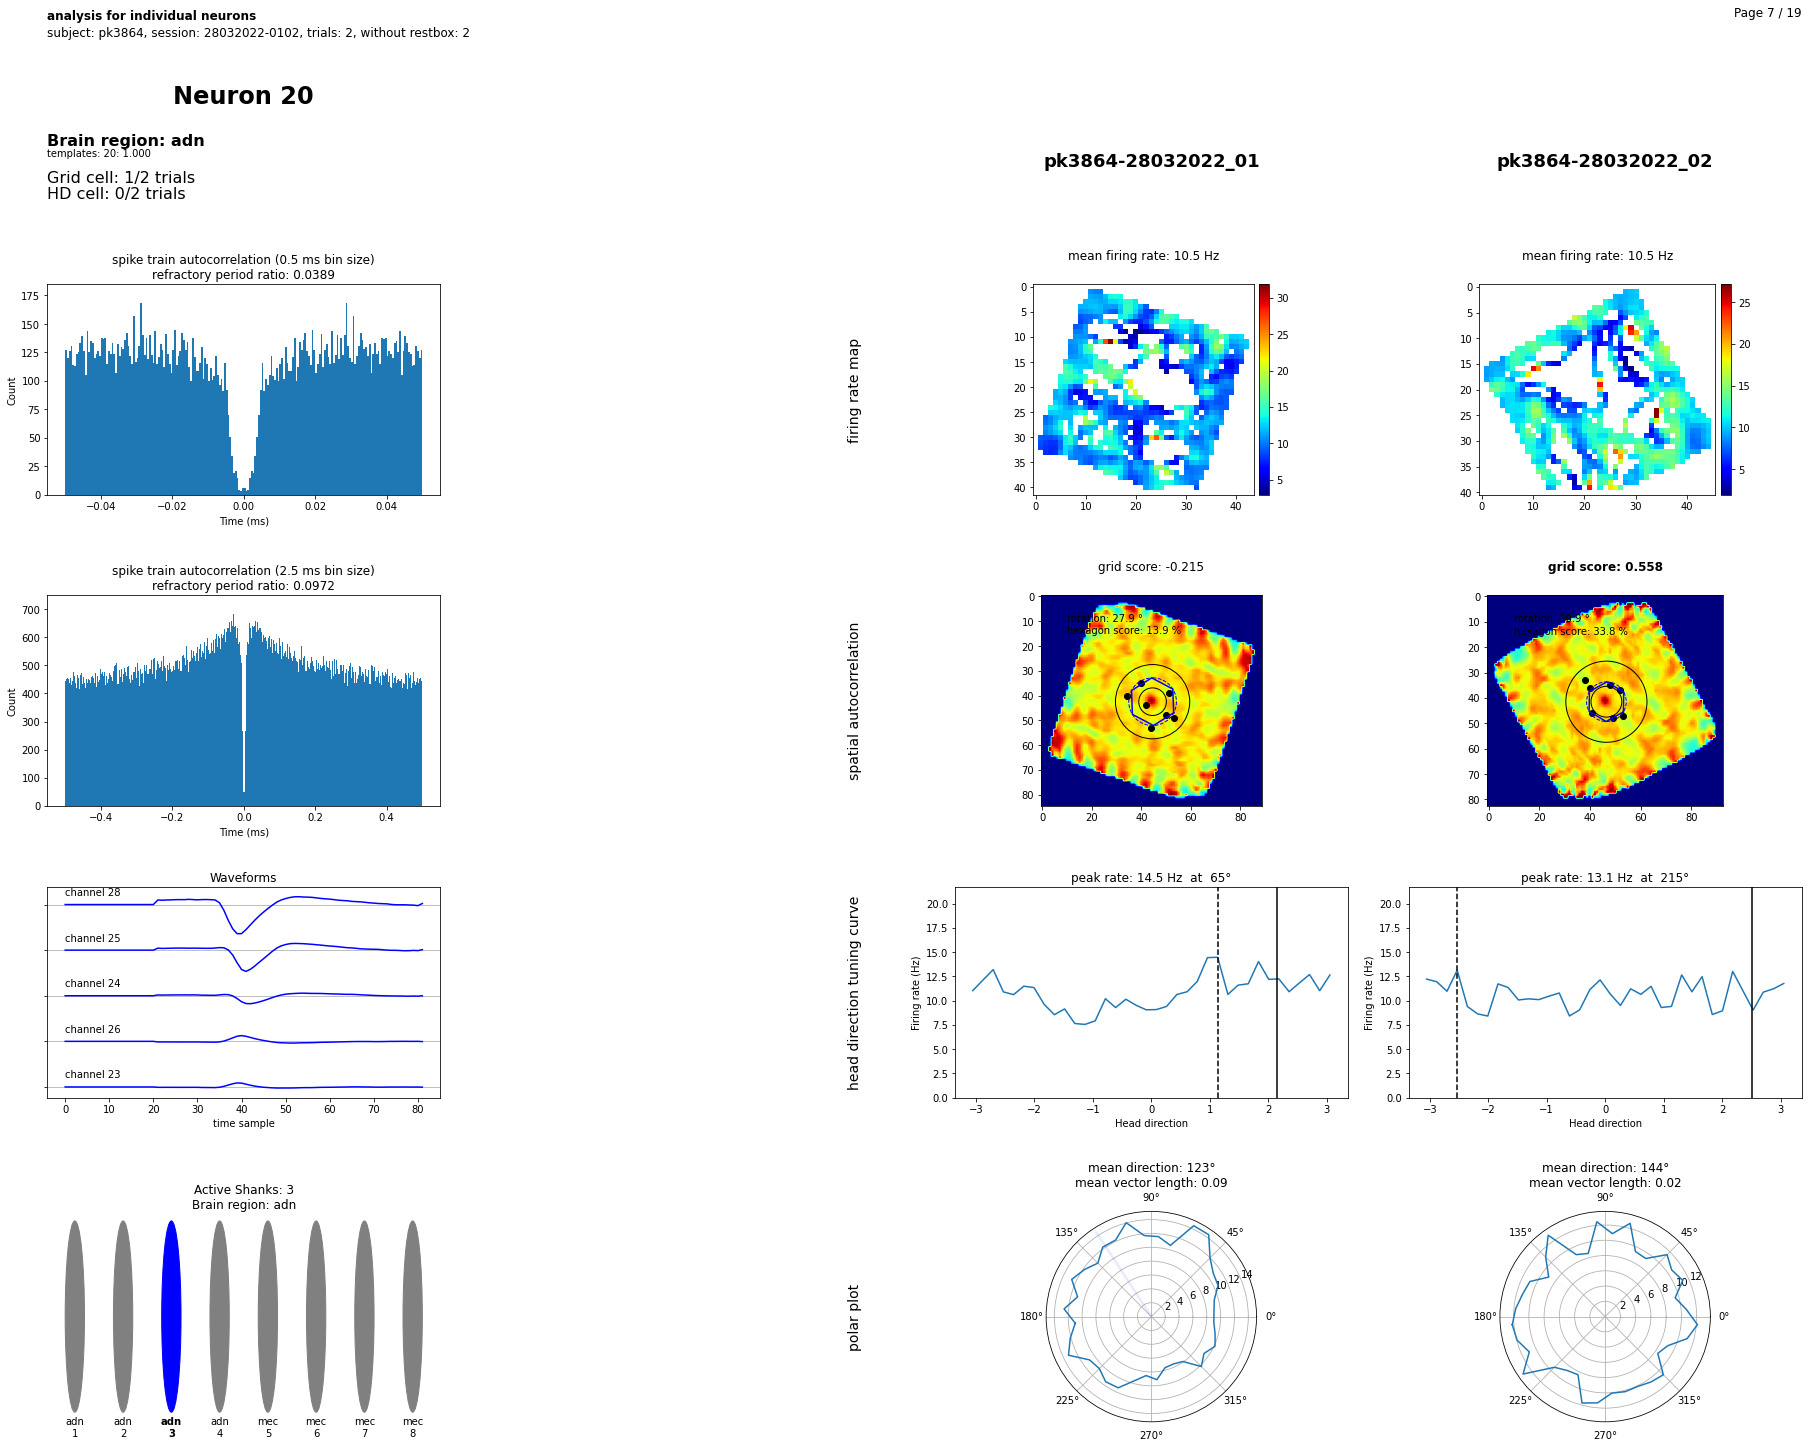

 37%|████████████████▏                           | 7/19 [00:44<01:17,  6.44s/it]/tmp/ipykernel_3573/1964801147.py:60: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim((0,np.max(n.spike_train.st_autocorrelation_histogram[0])*1.1))
/tmp/ipykernel_3573/1964801147.py:69: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim((0,np.max(n.spike_train.st_autocorrelation_histogram[0])*1.1))


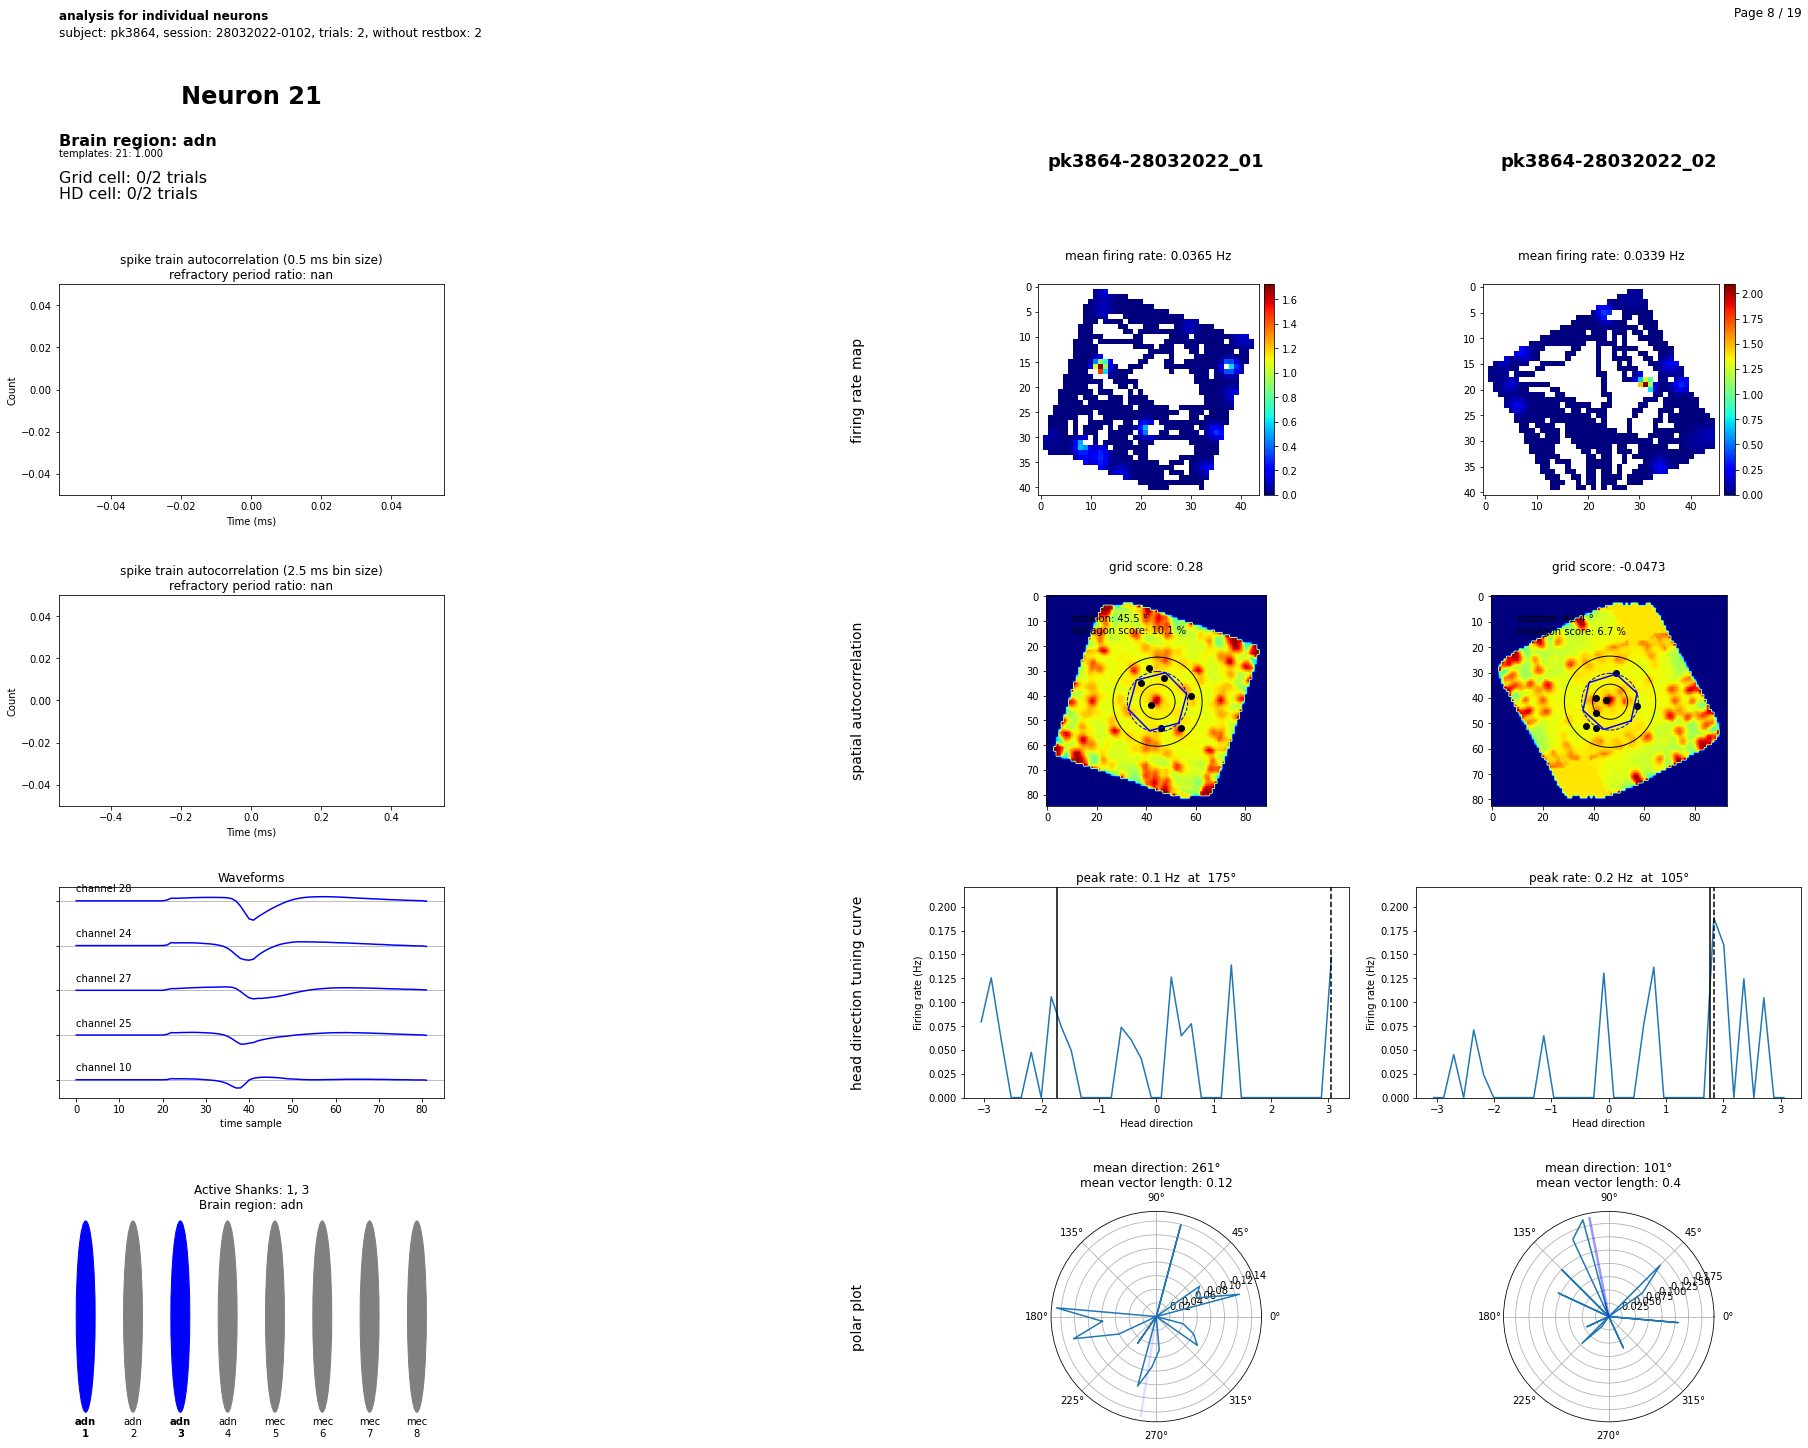

 42%|██████████████████▌                         | 8/19 [00:51<01:11,  6.47s/it]

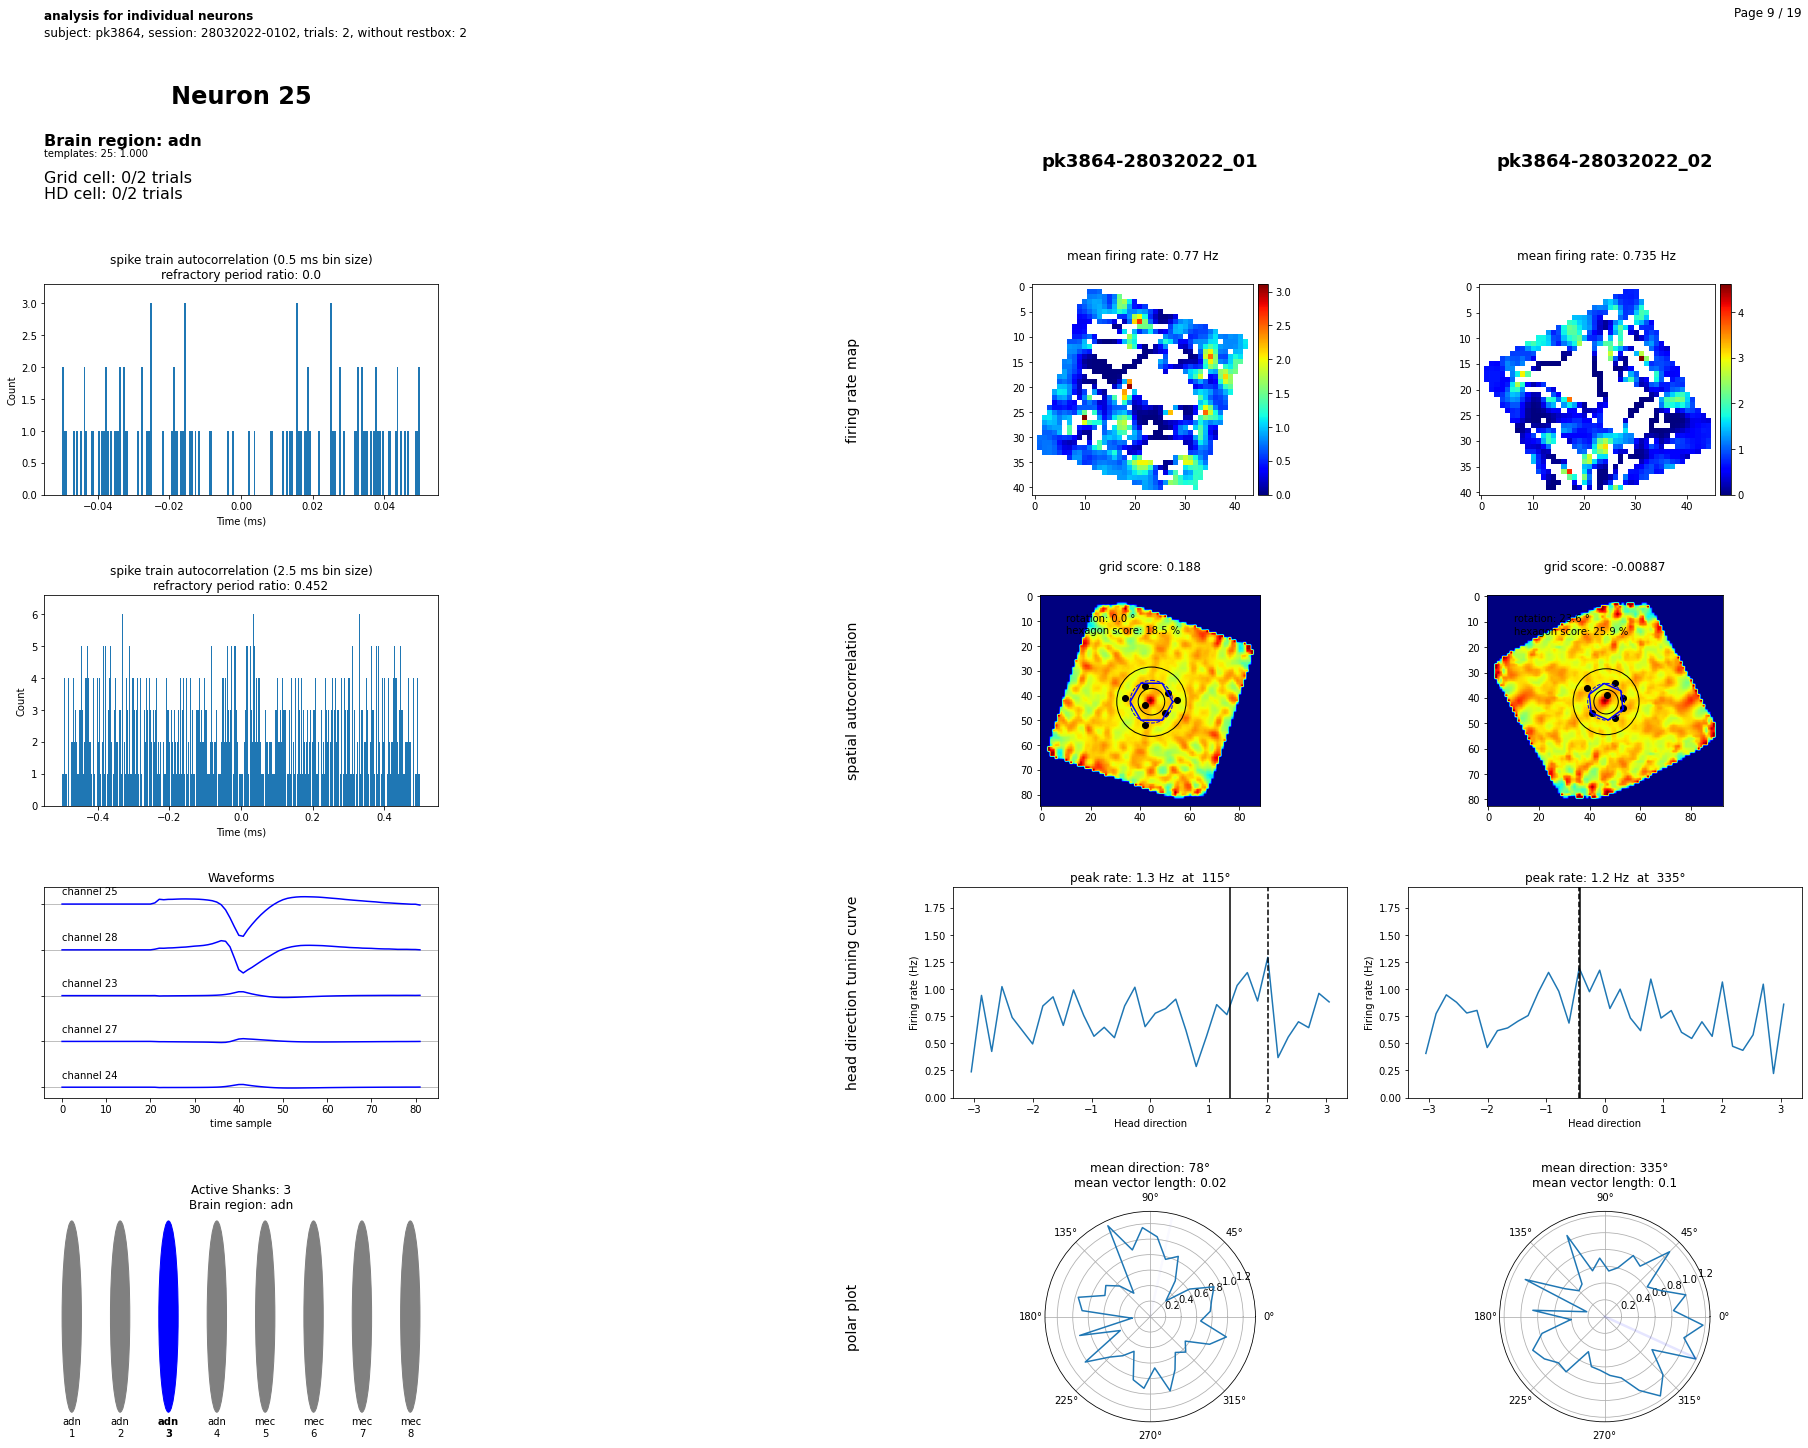

 47%|████████████████████▊                       | 9/19 [00:57<01:04,  6.42s/it]

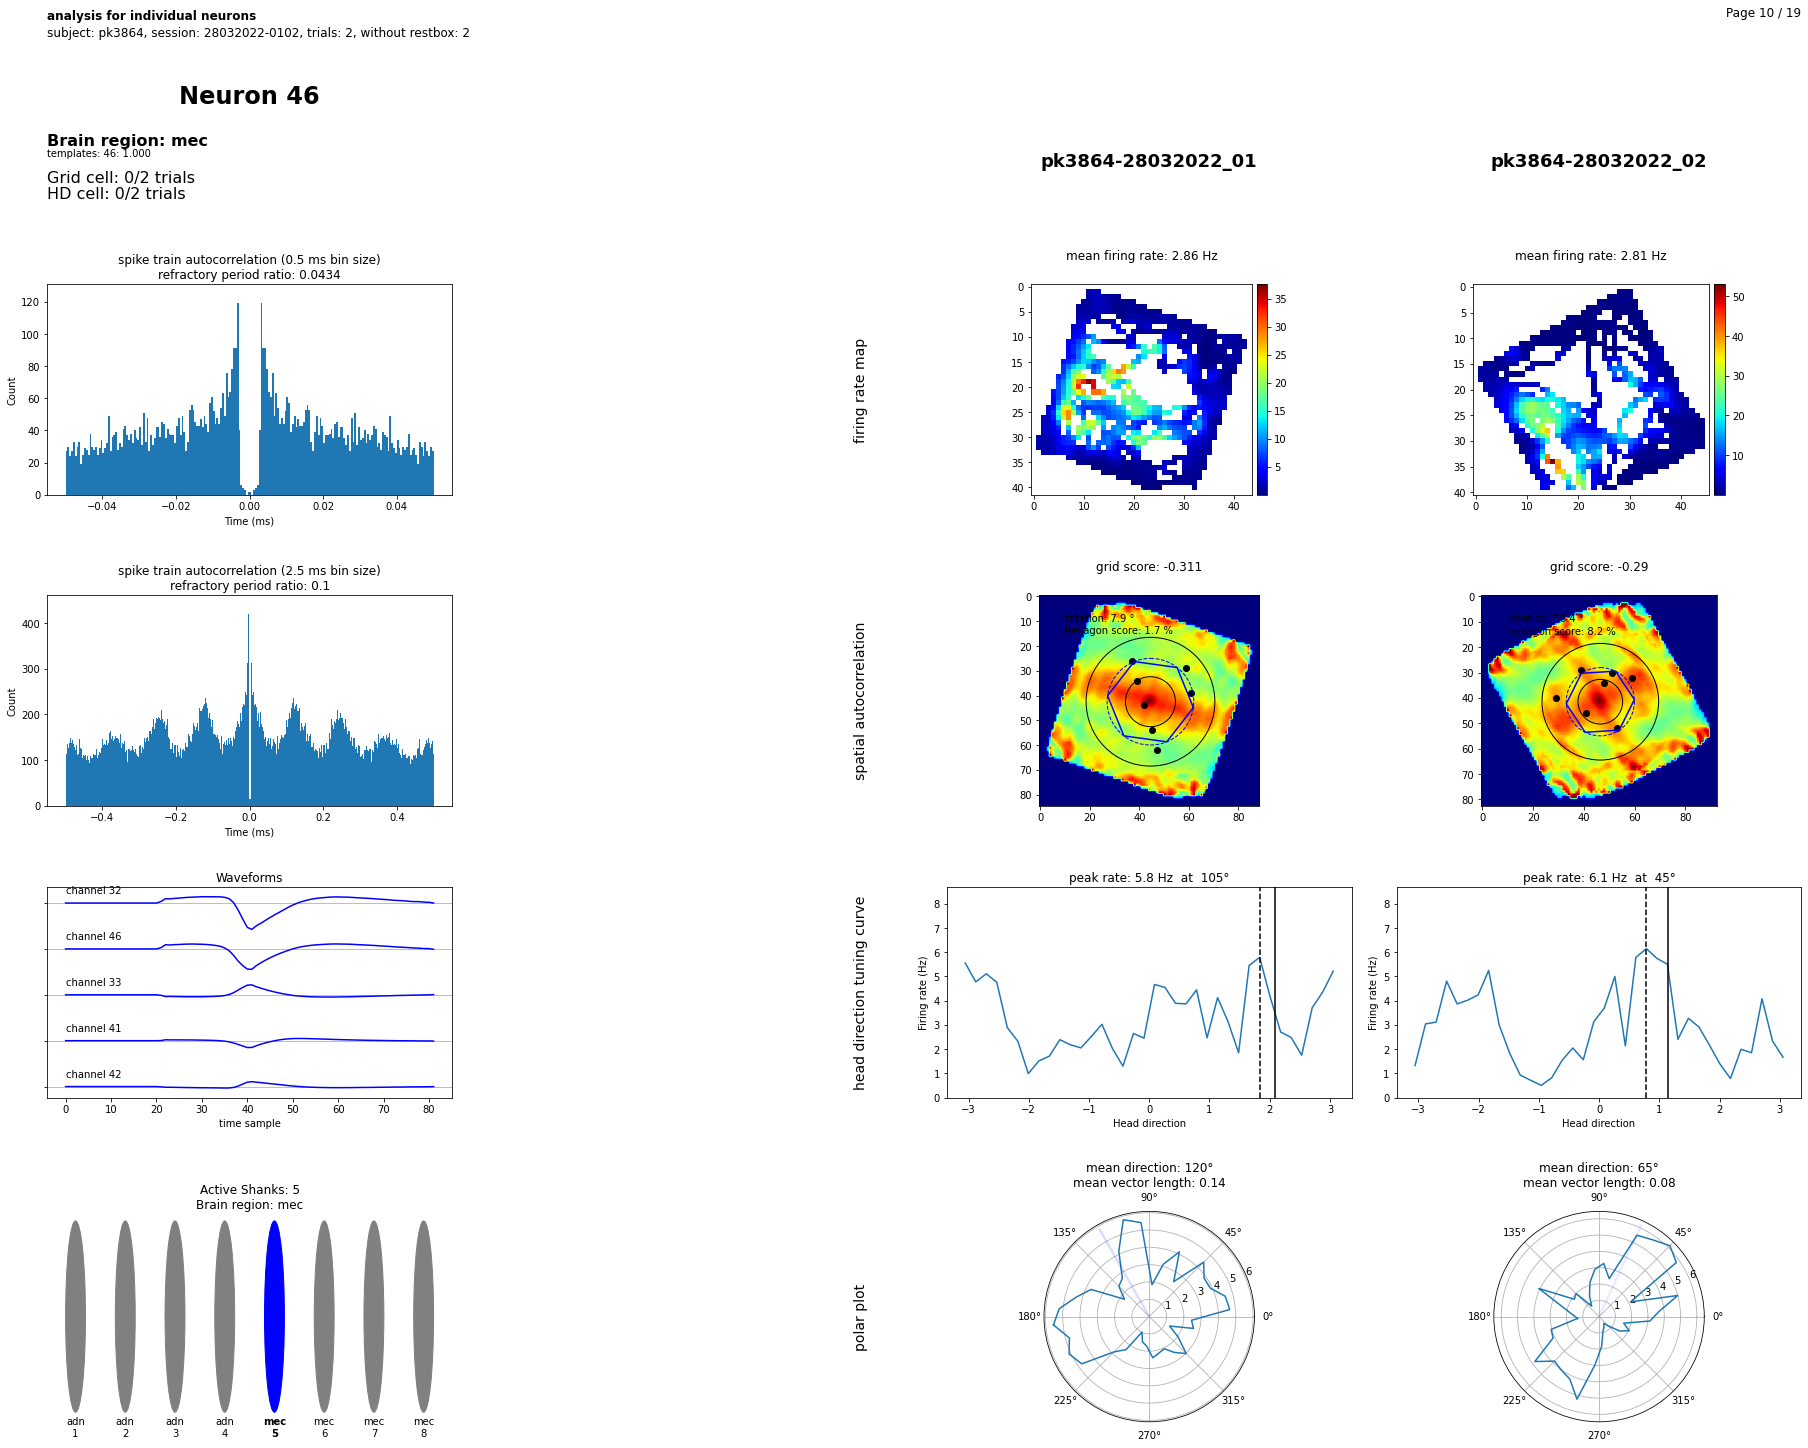

 53%|██████████████████████▋                    | 10/19 [01:03<00:57,  6.34s/it]/tmp/ipykernel_3573/1964801147.py:60: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim((0,np.max(n.spike_train.st_autocorrelation_histogram[0])*1.1))
/tmp/ipykernel_3573/1964801147.py:69: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim((0,np.max(n.spike_train.st_autocorrelation_histogram[0])*1.1))


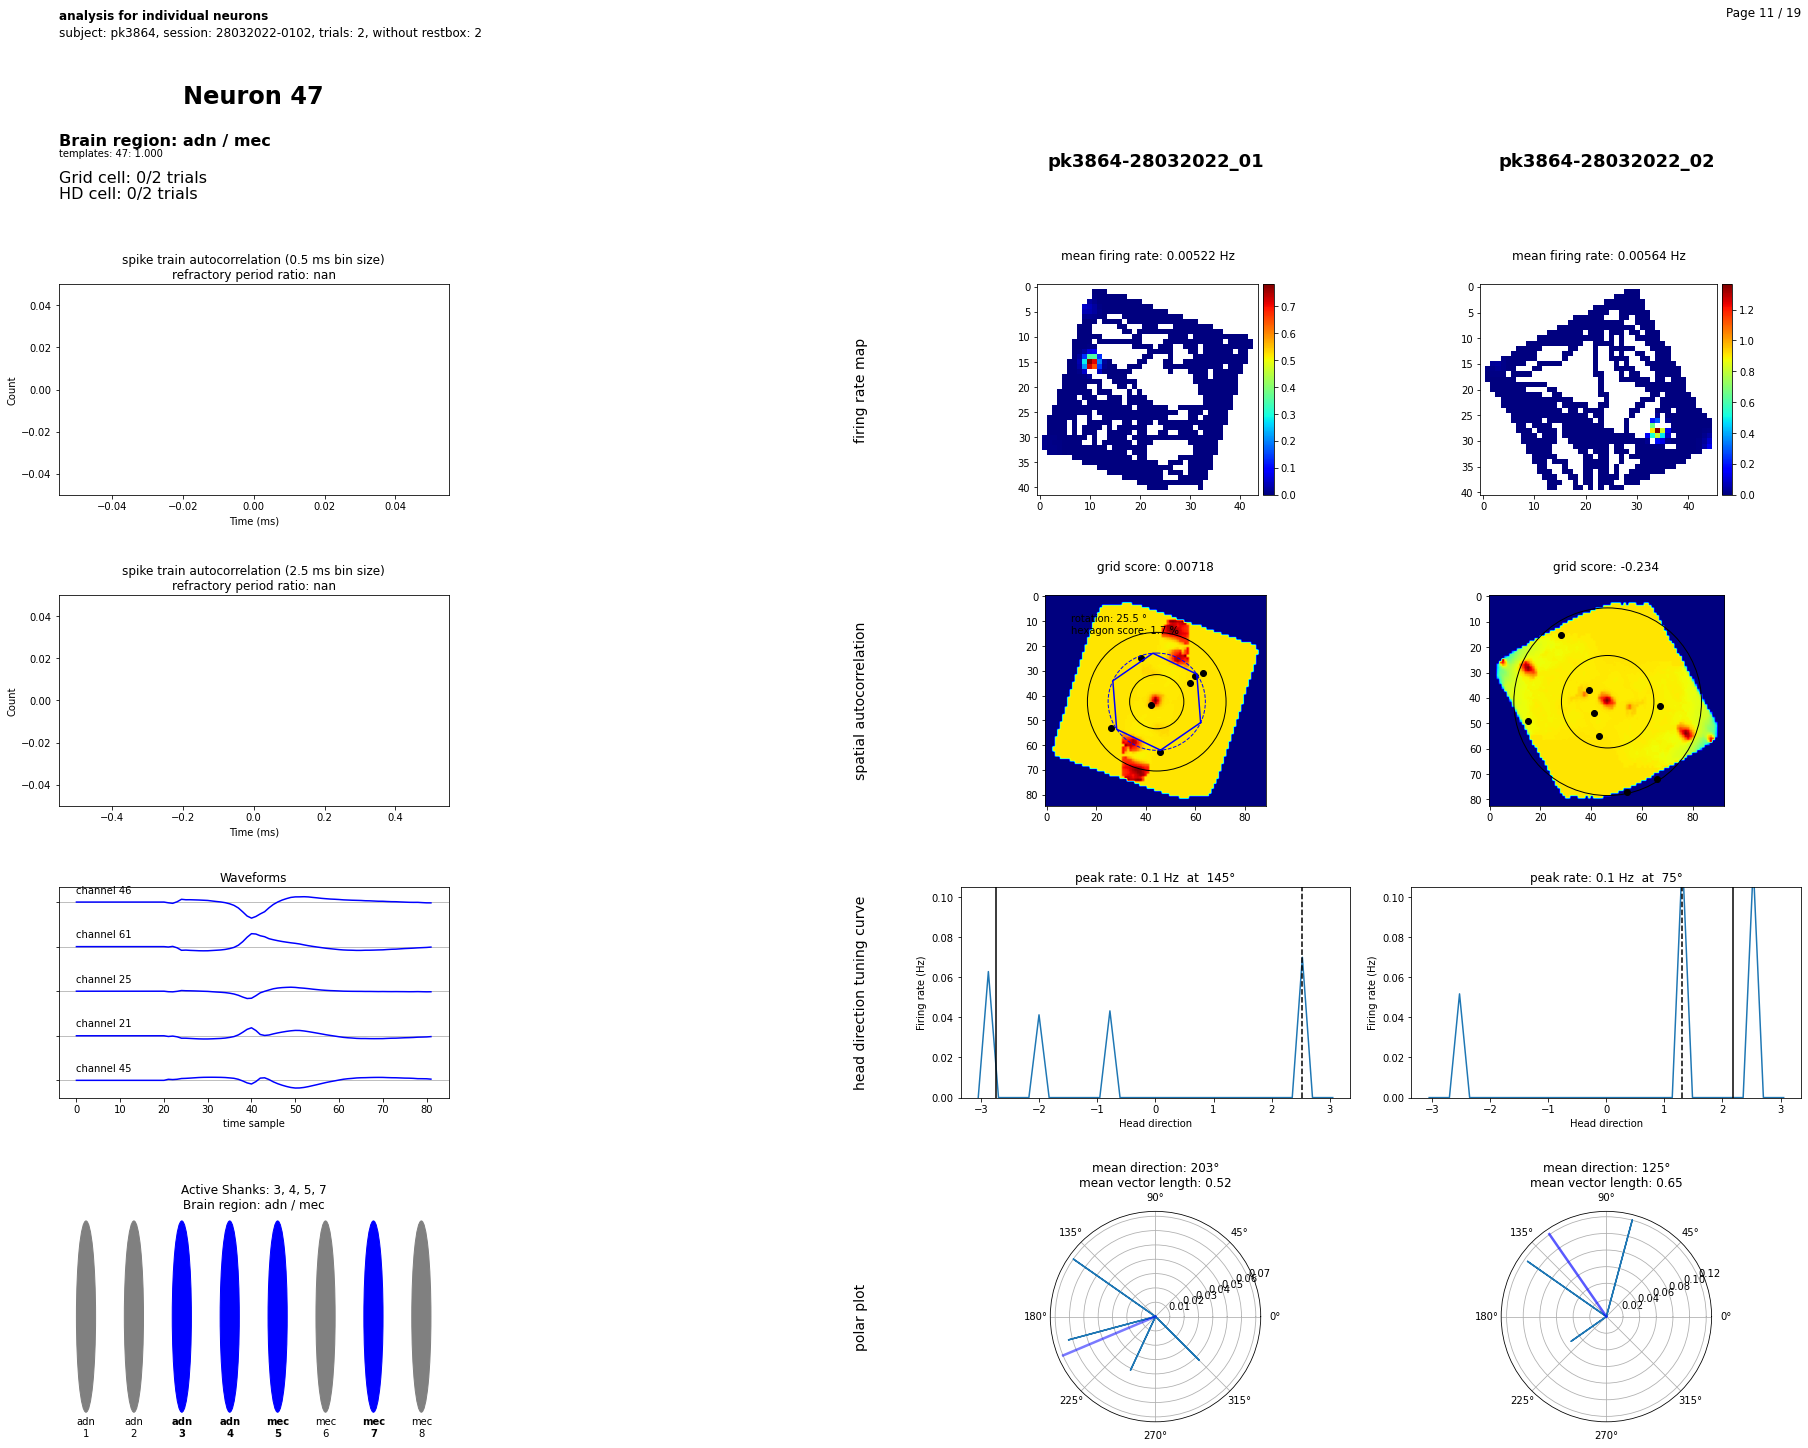

 58%|████████████████████████▉                  | 11/19 [01:09<00:50,  6.31s/it]

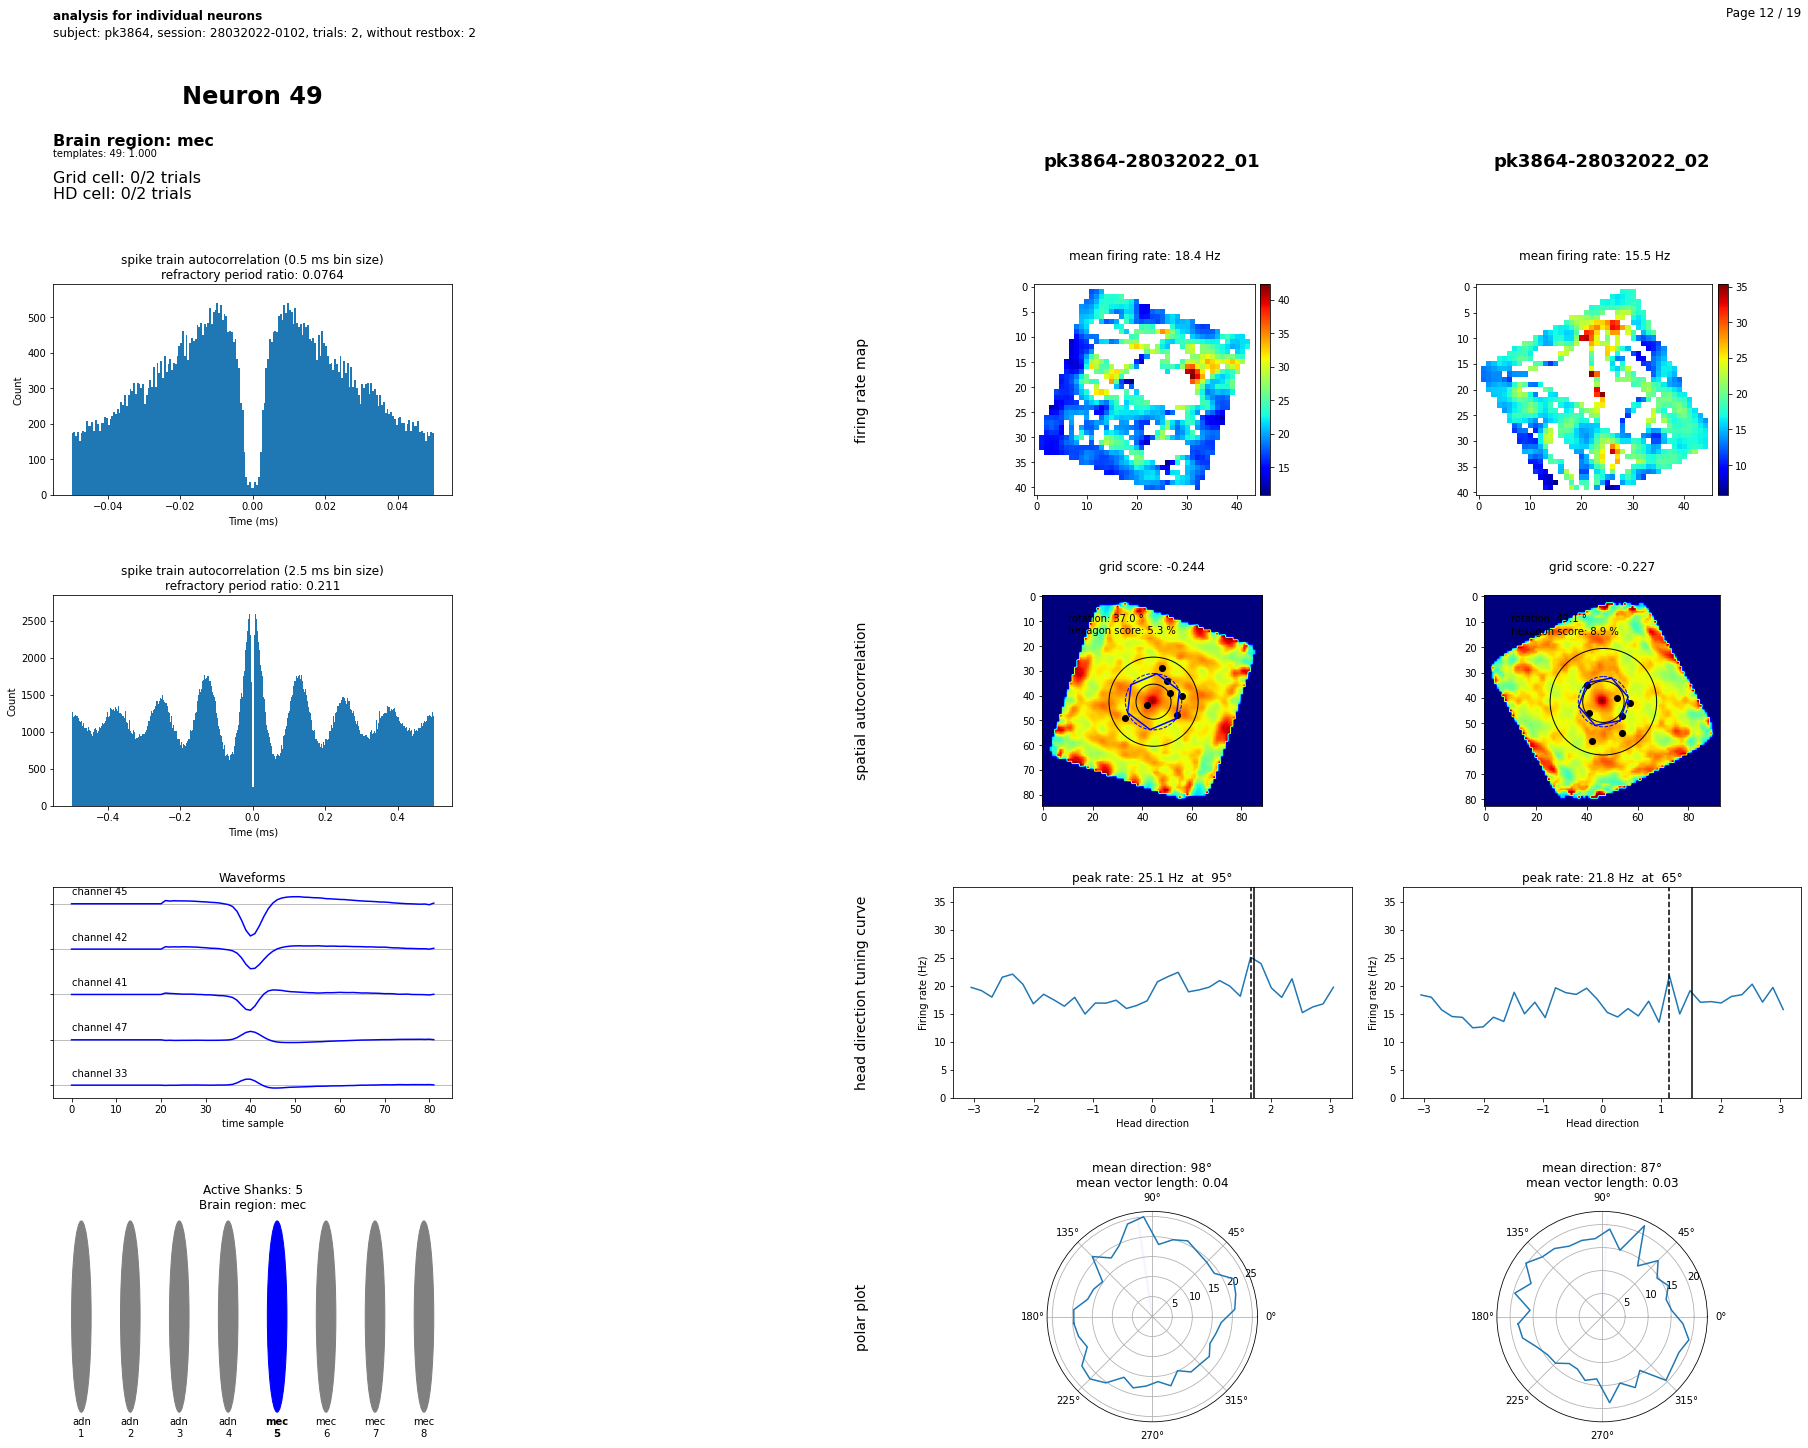

 63%|███████████████████████████▏               | 12/19 [01:16<00:44,  6.34s/it]

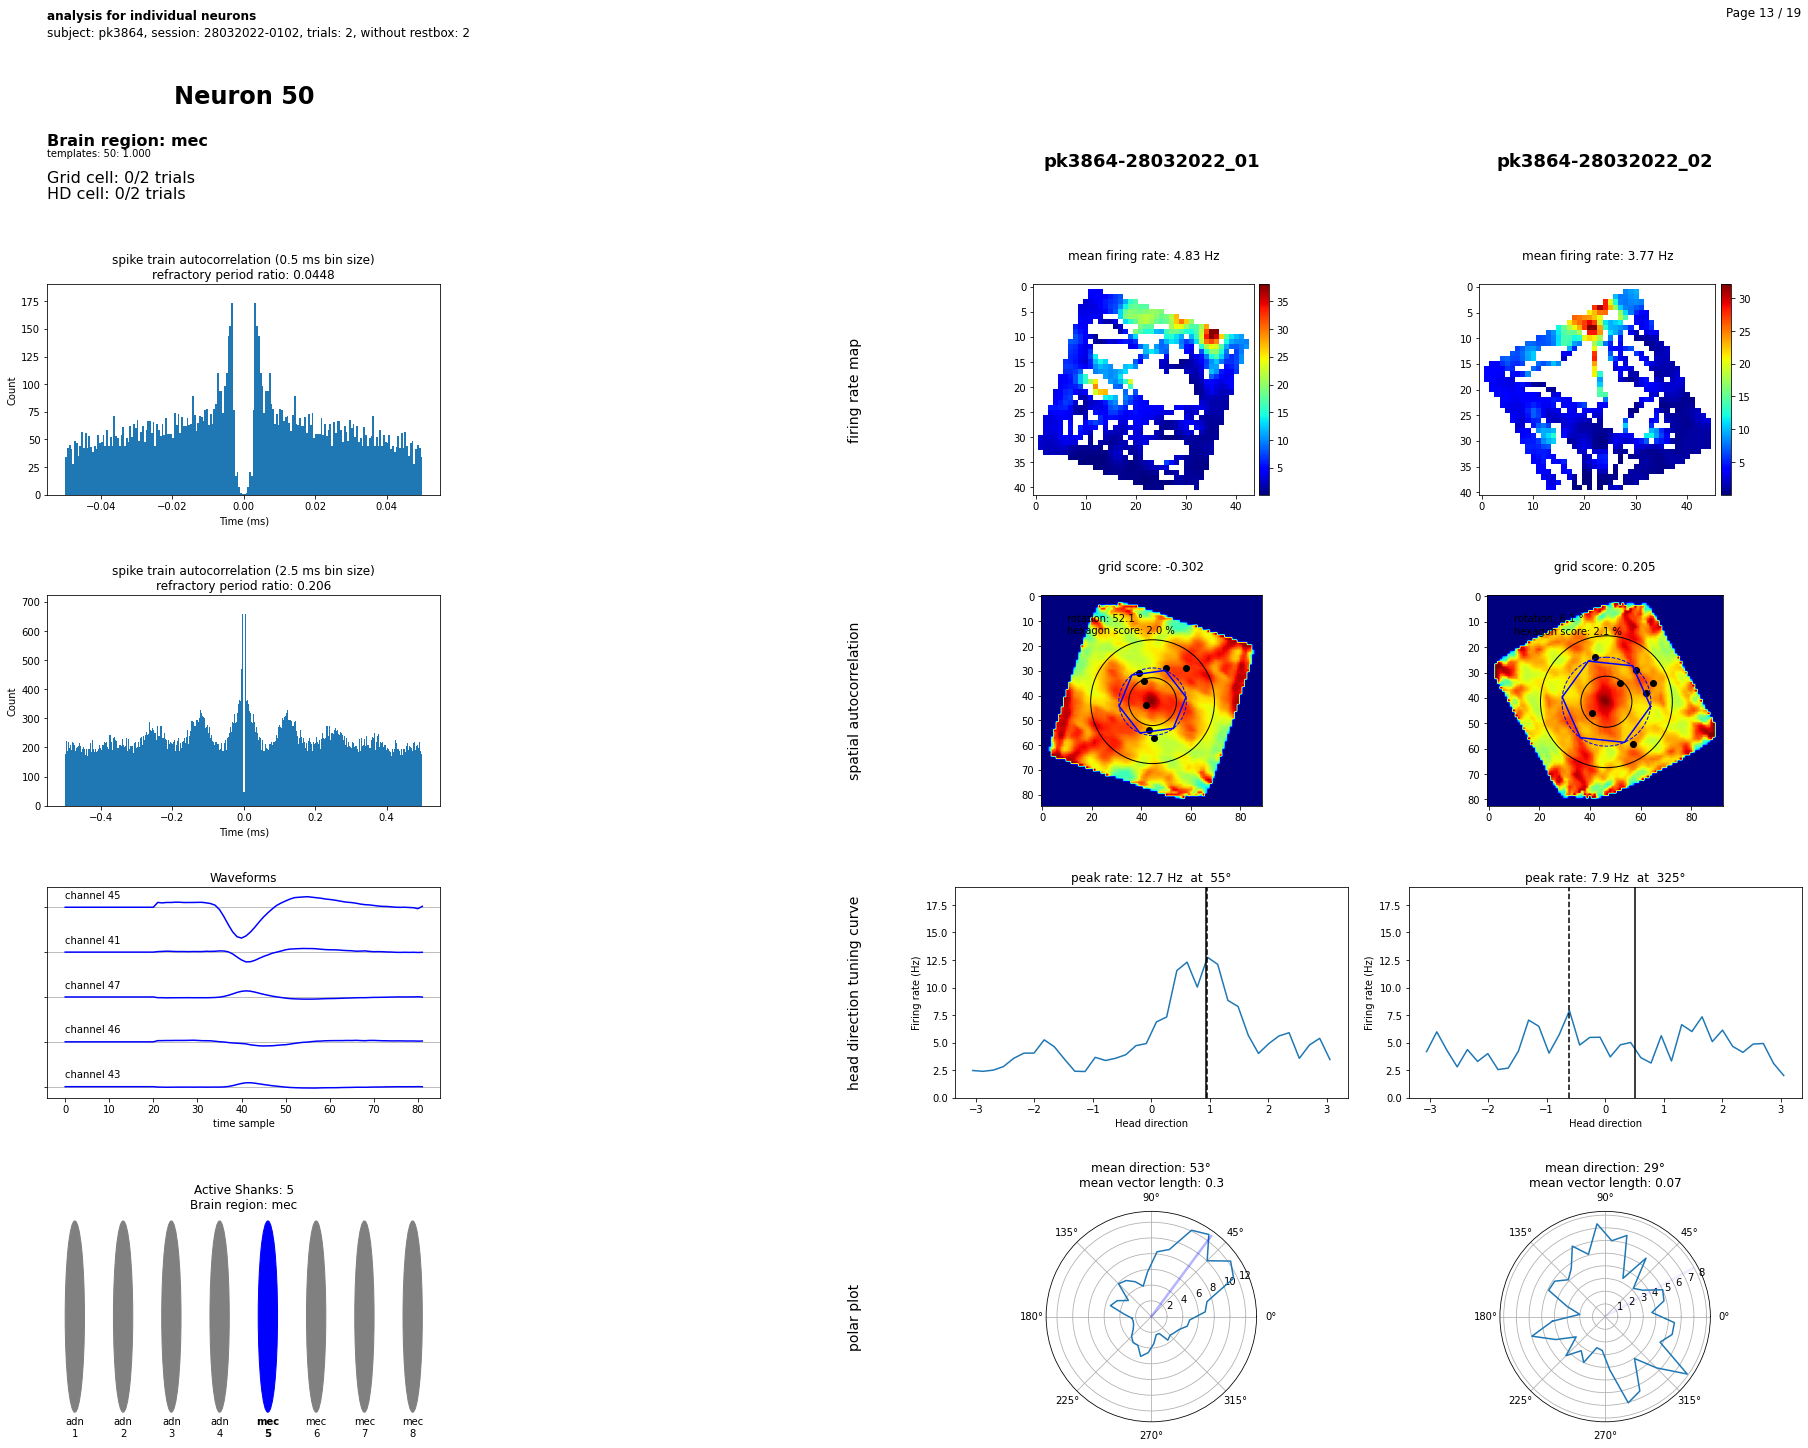

 68%|█████████████████████████████▍             | 13/19 [01:22<00:38,  6.40s/it]

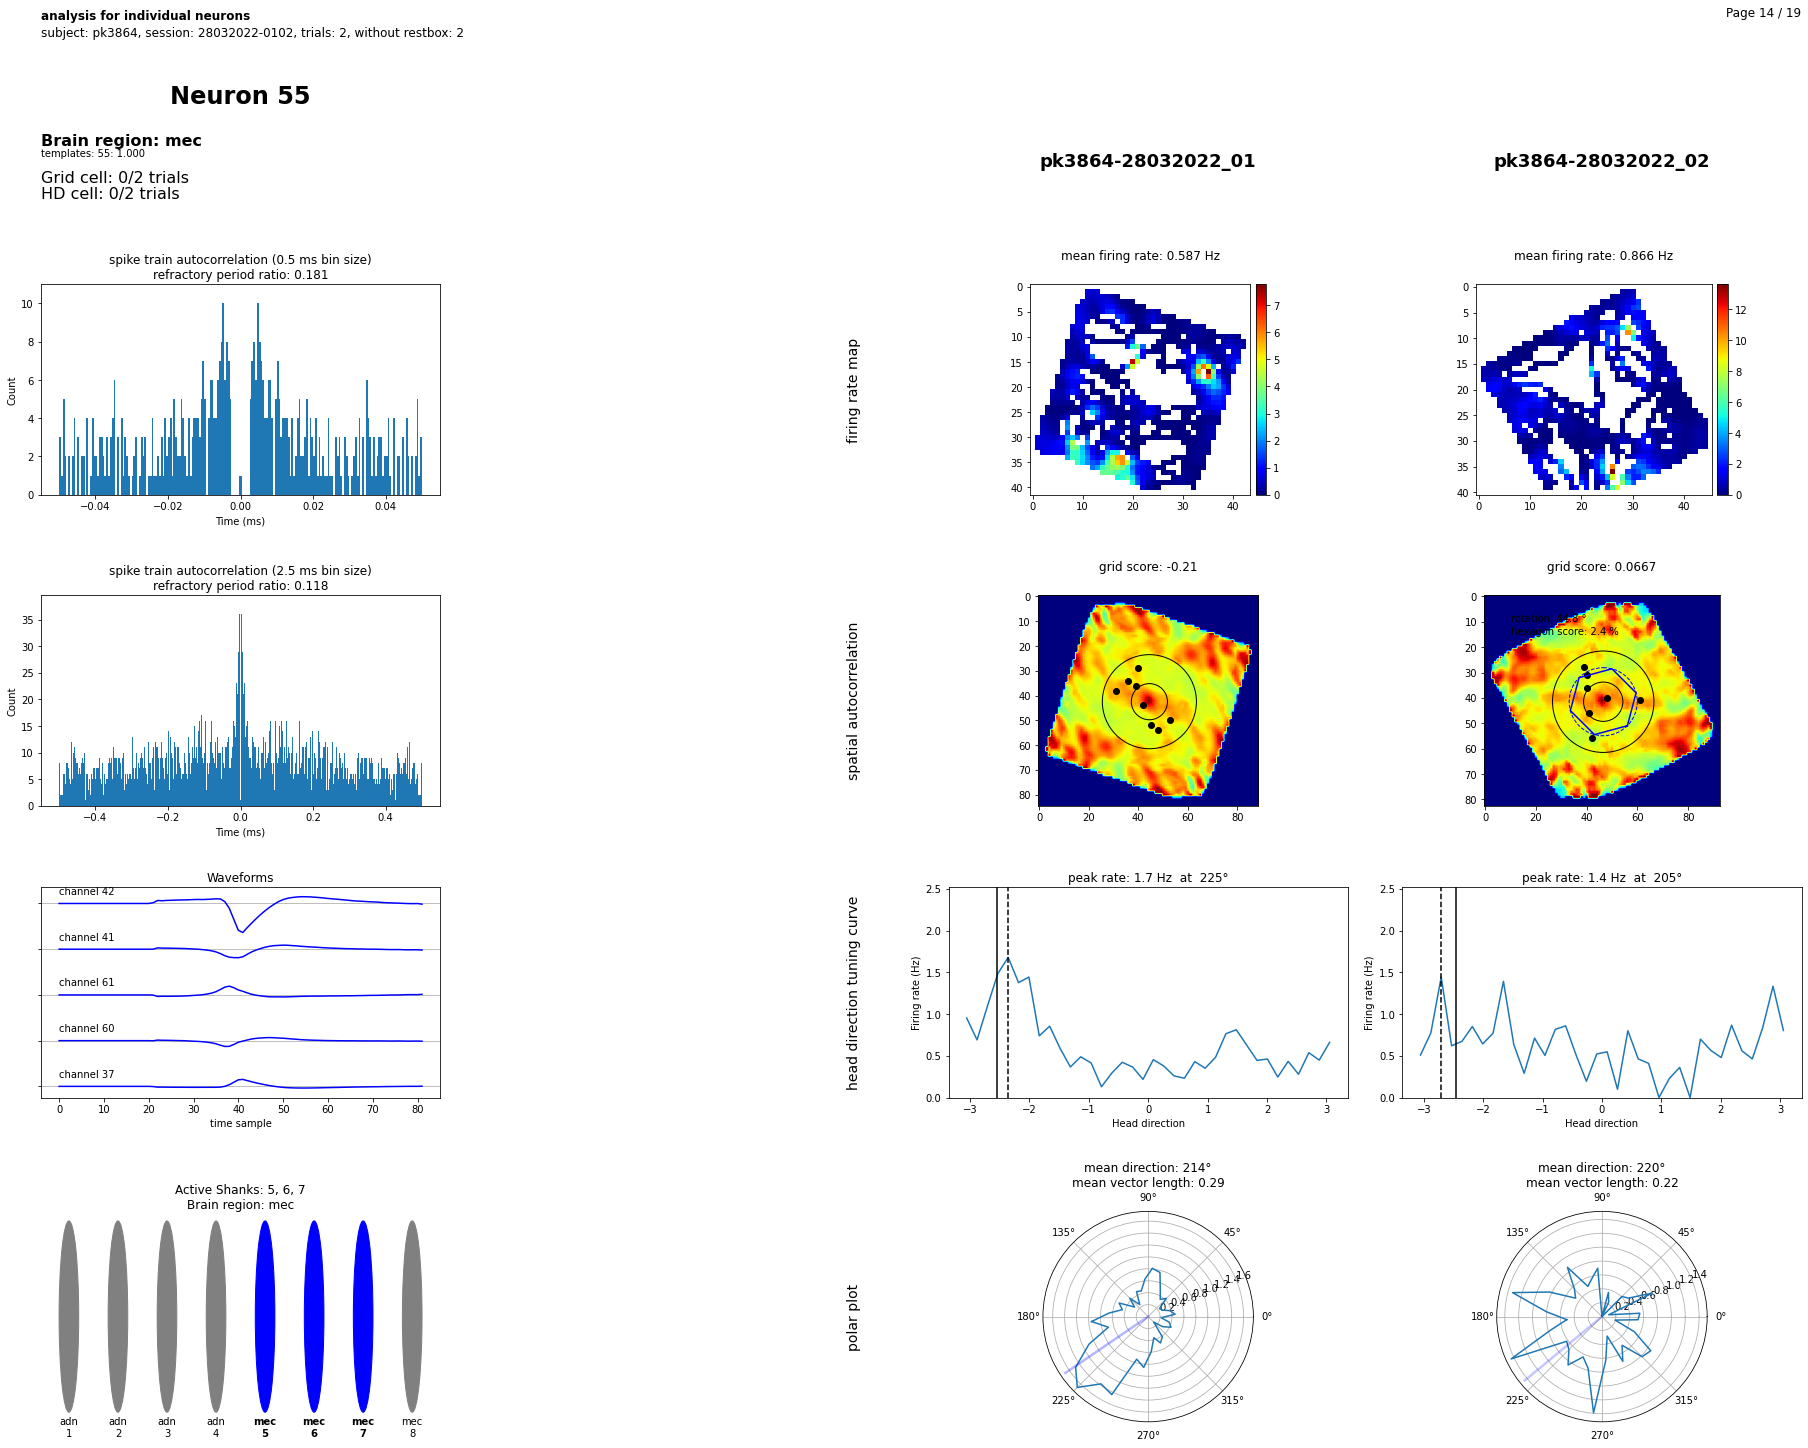

 74%|███████████████████████████████▋           | 14/19 [01:29<00:31,  6.34s/it]

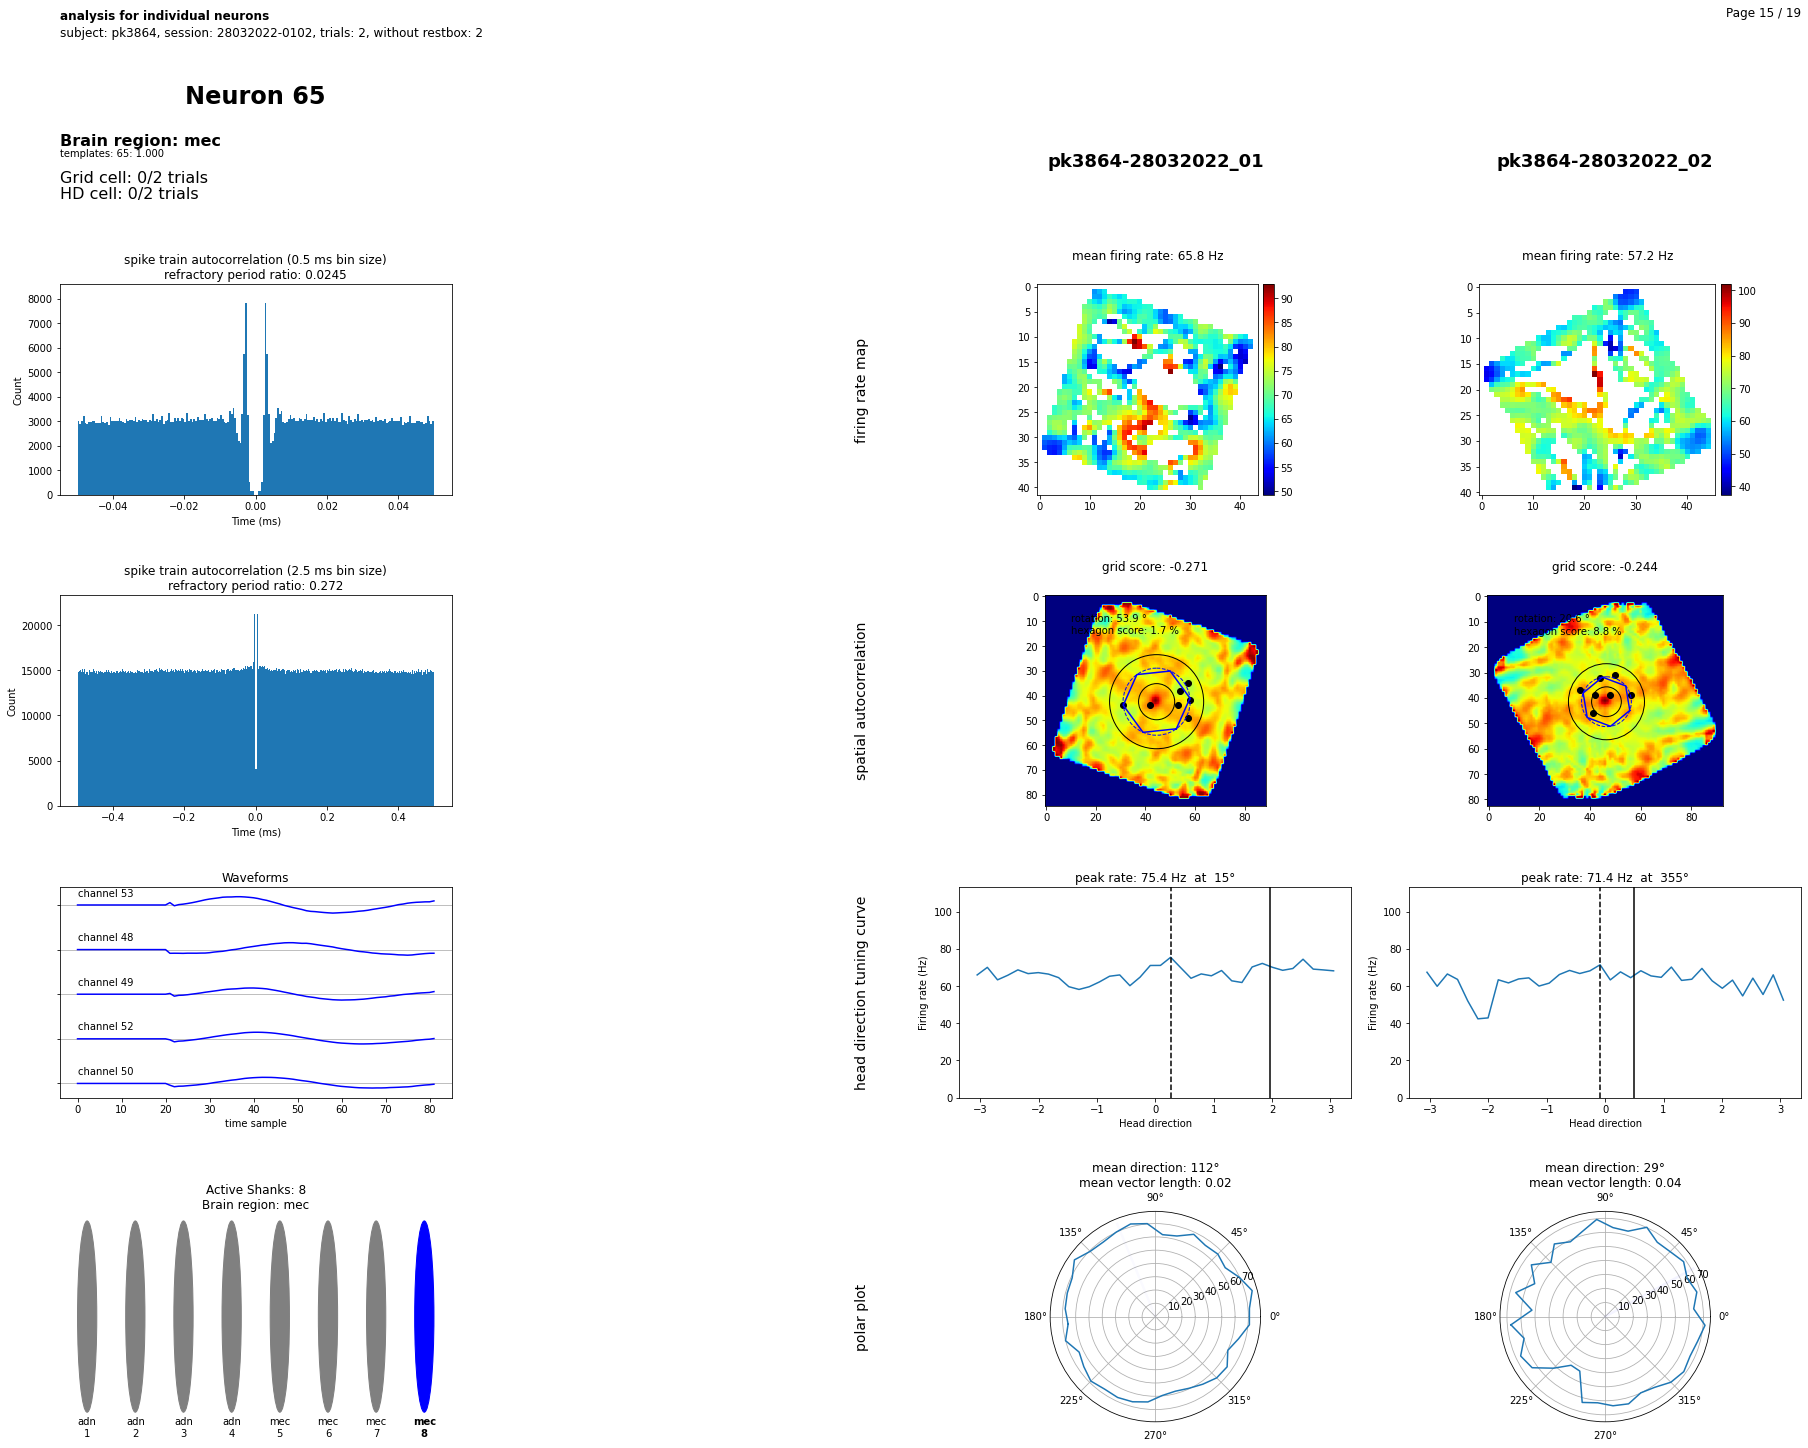

 79%|█████████████████████████████████▉         | 15/19 [01:35<00:25,  6.38s/it]

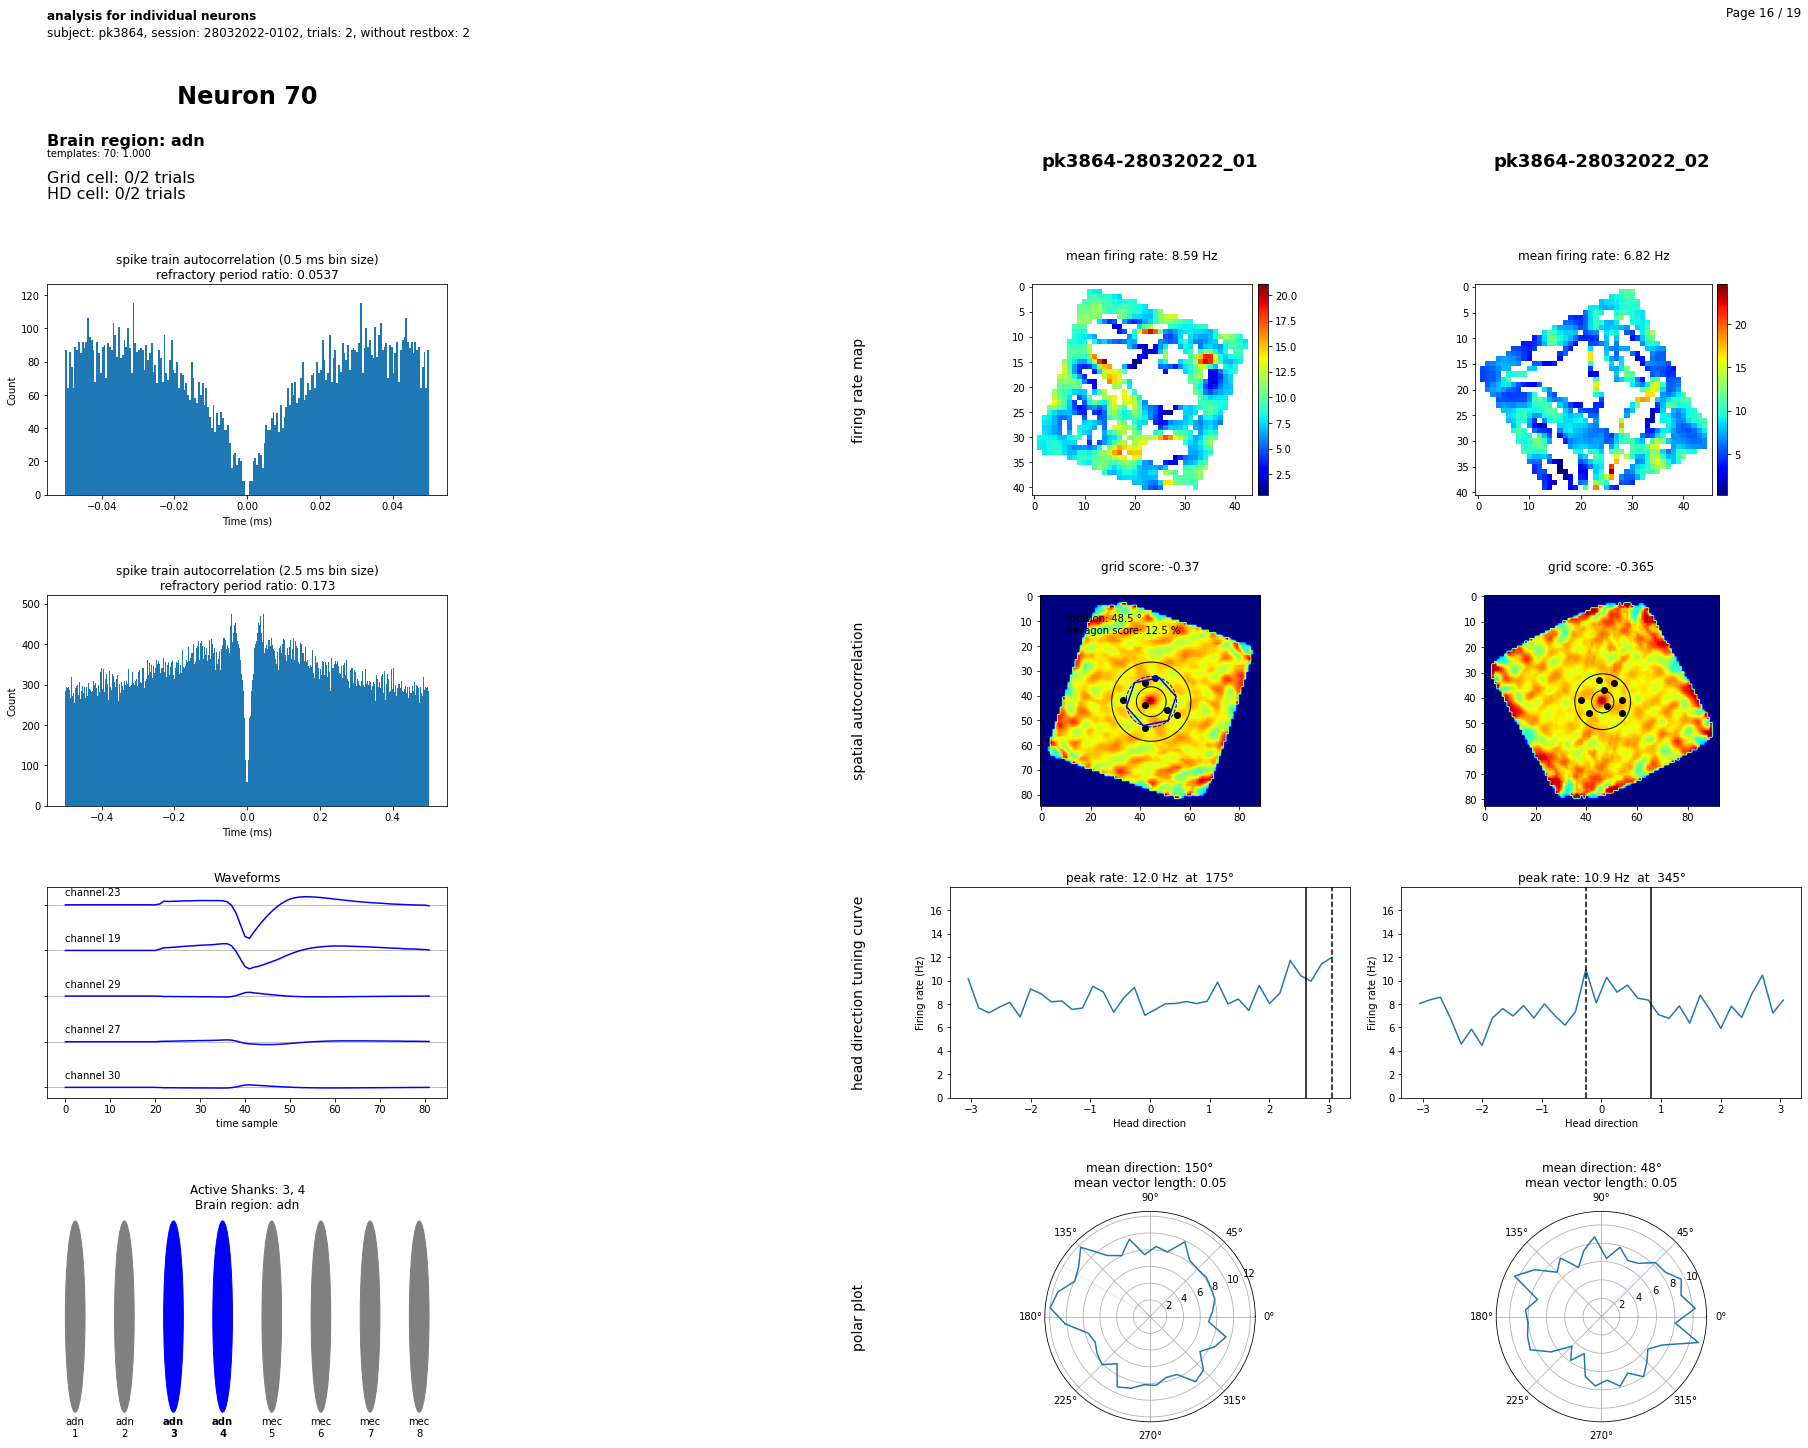

 84%|████████████████████████████████████▏      | 16/19 [01:42<00:19,  6.47s/it]

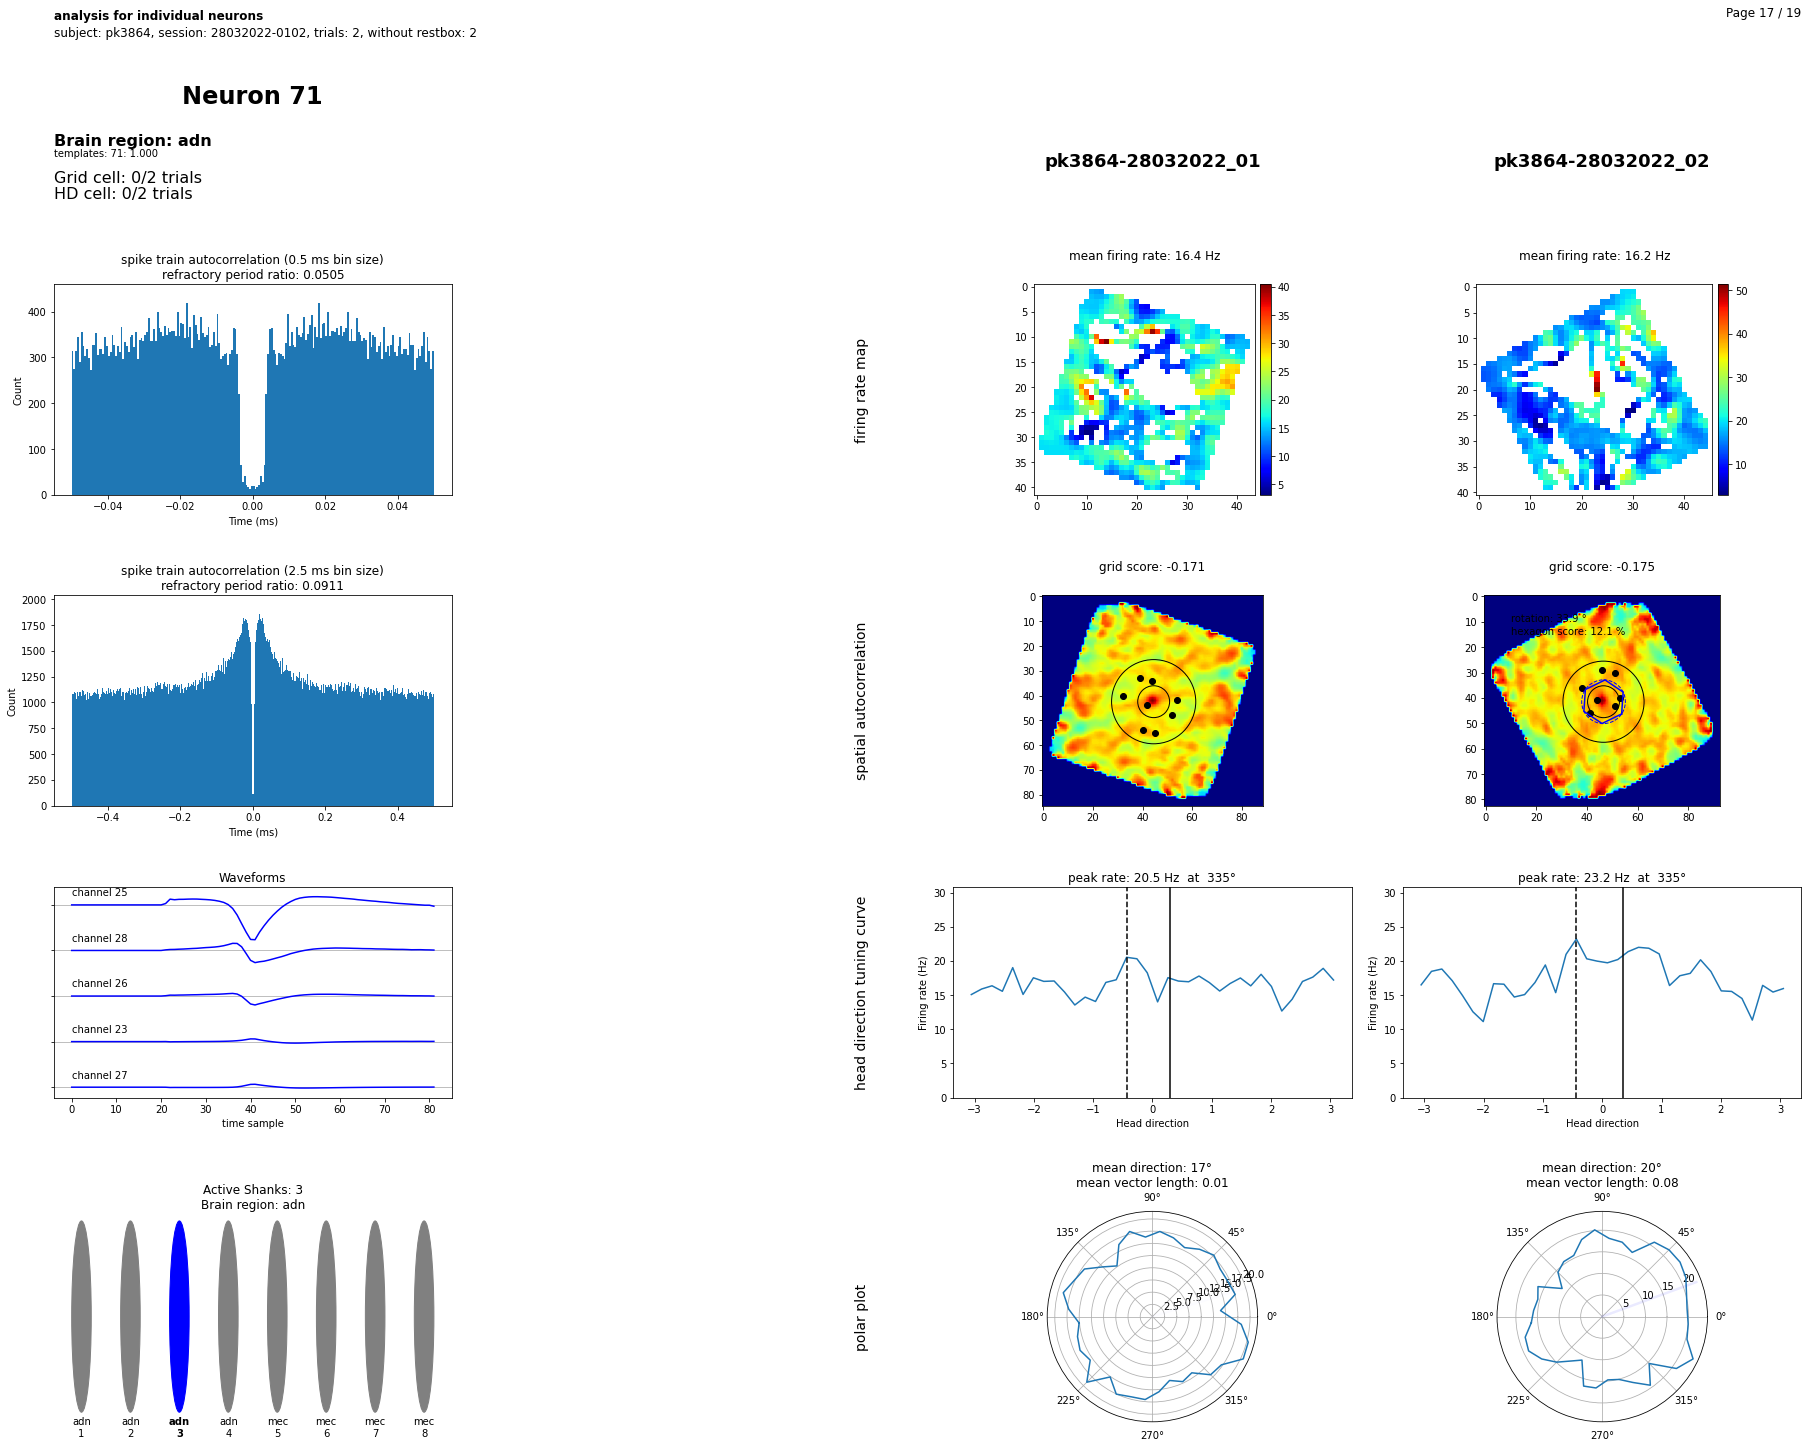

 89%|██████████████████████████████████████▍    | 17/19 [01:48<00:12,  6.38s/it]

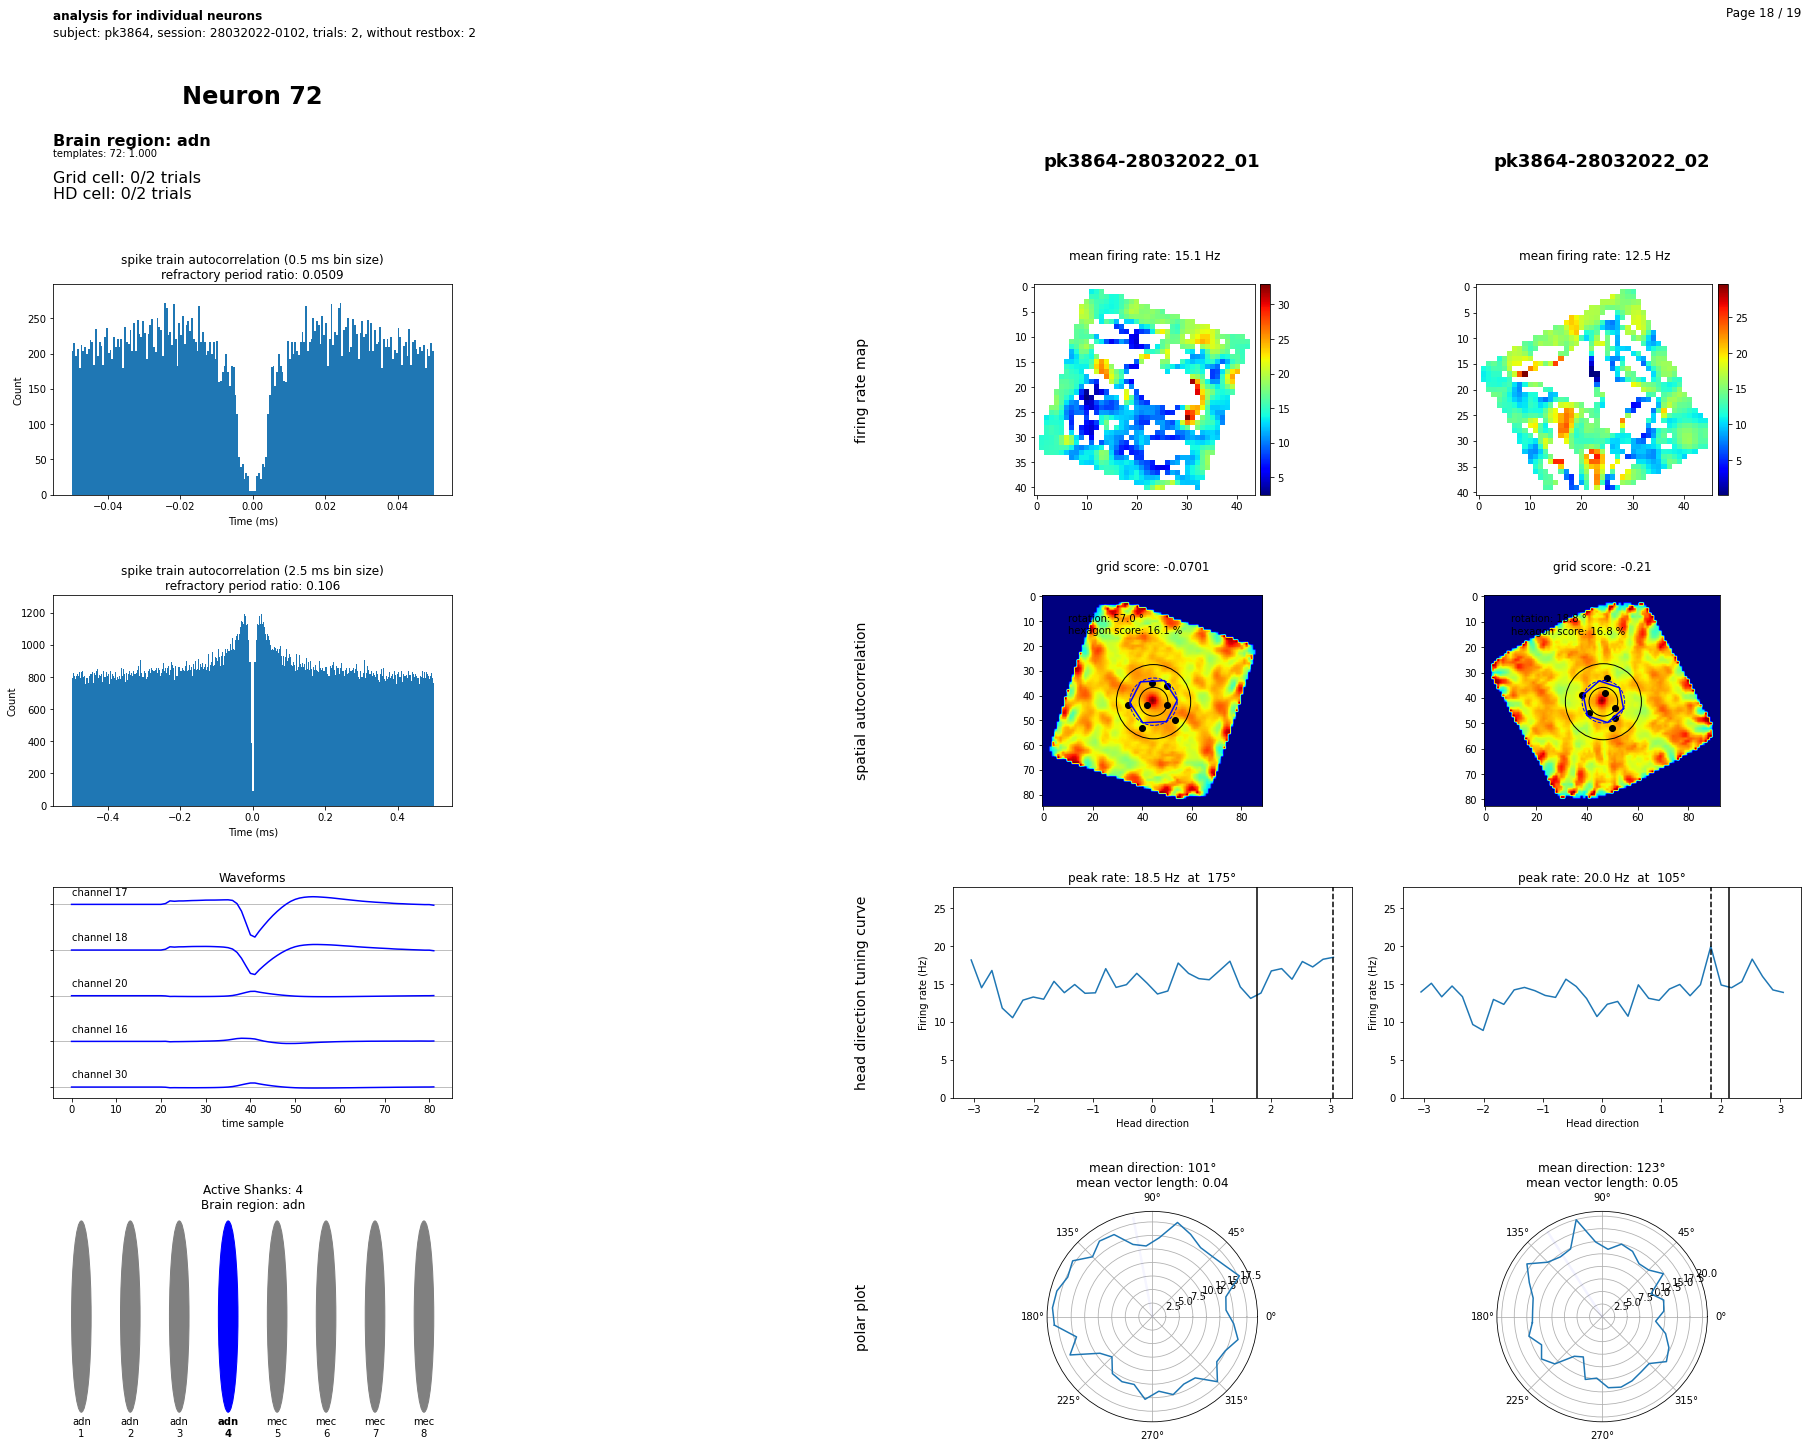

 95%|████████████████████████████████████████▋  | 18/19 [01:54<00:06,  6.37s/it]

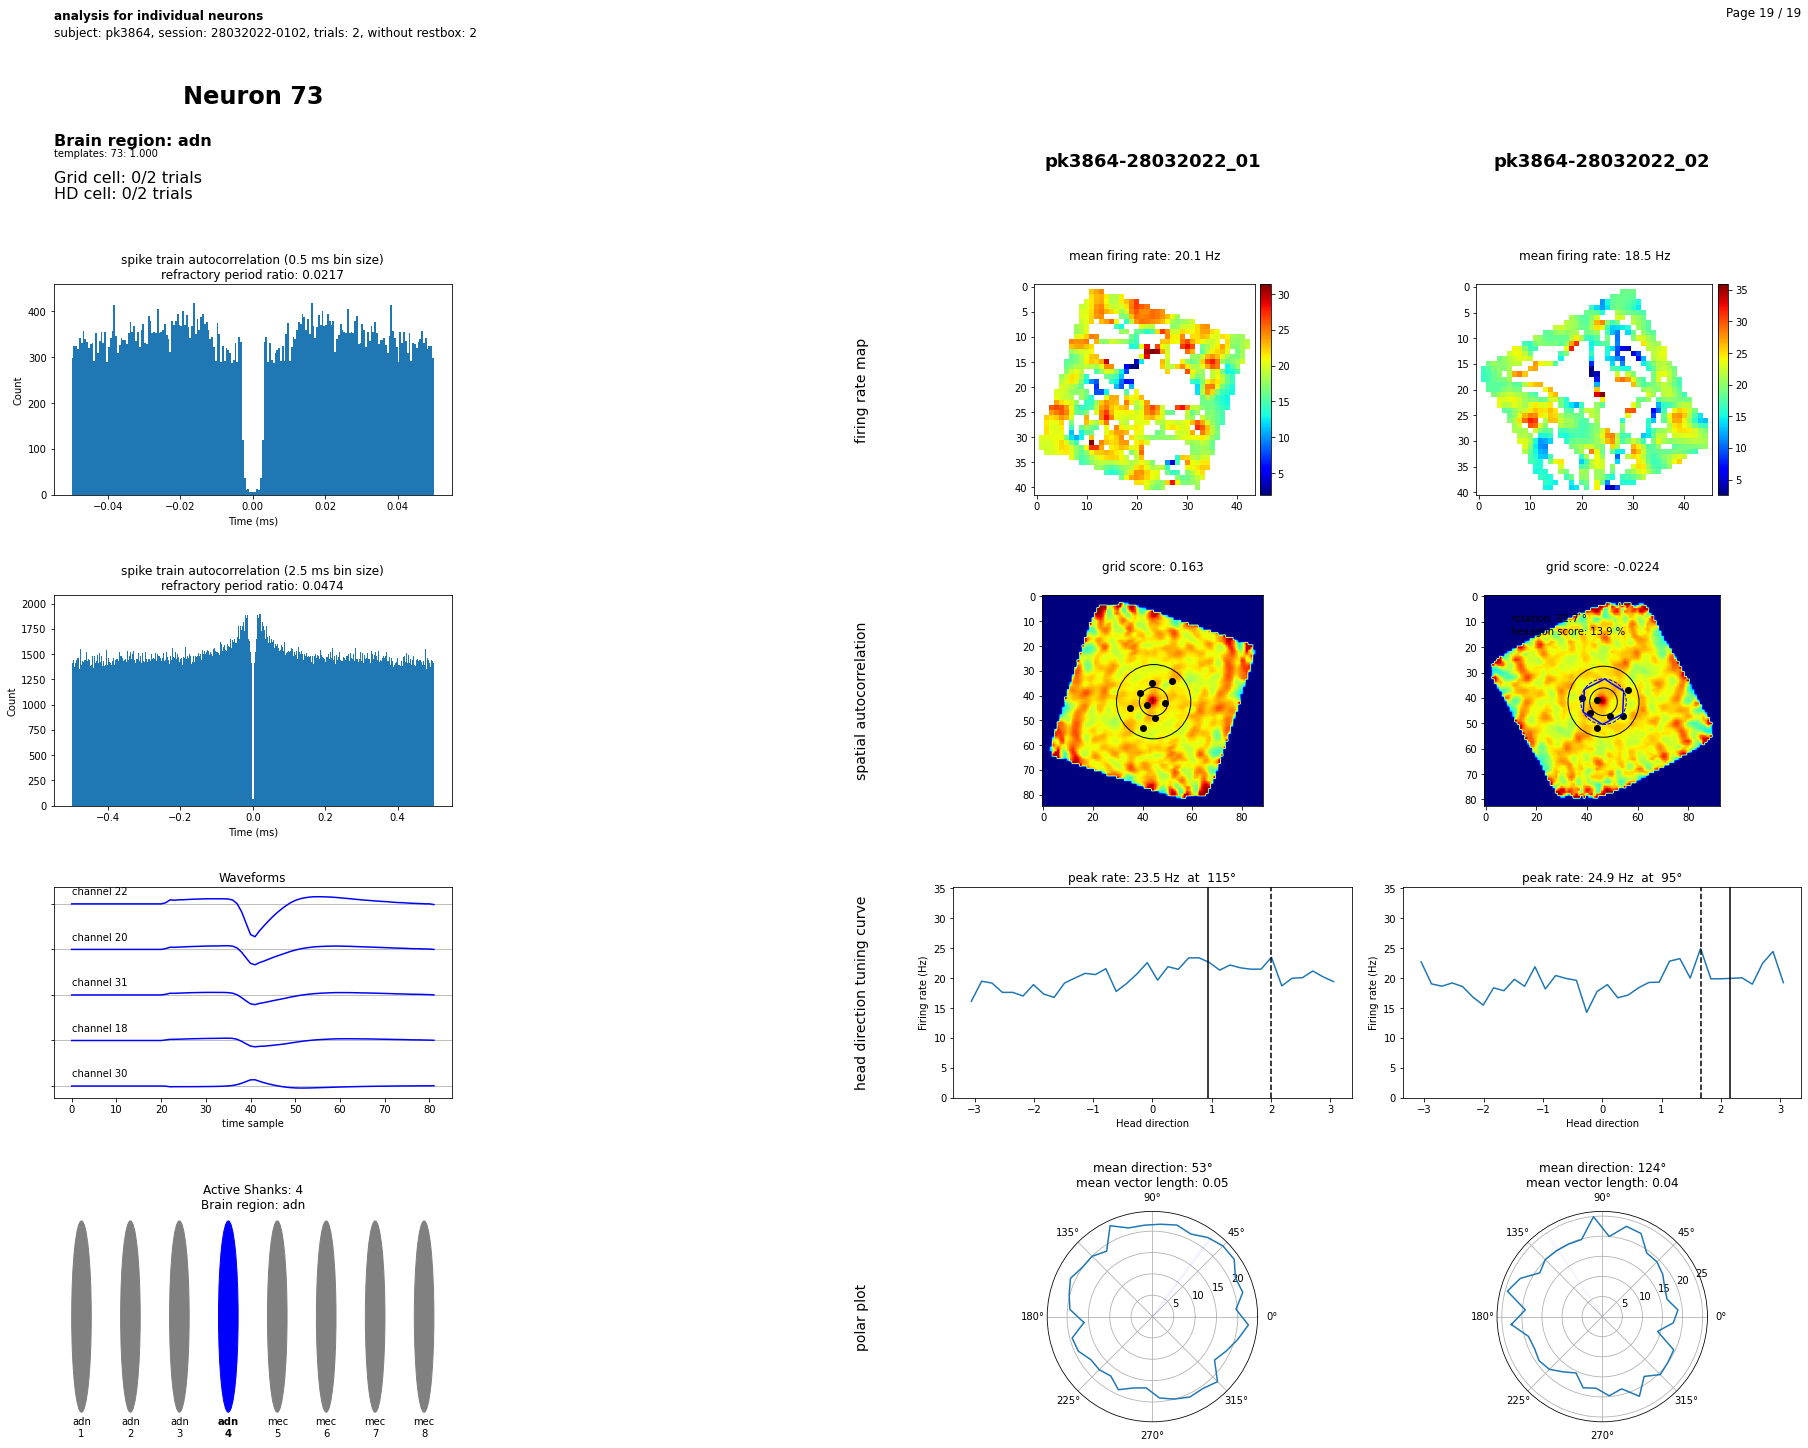

100%|███████████████████████████████████████████| 19/19 [02:00<00:00,  6.36s/it]


In [47]:
pdf = matplotlib.backends.backend_pdf.PdfPages("/home/pascal/Documents/science_docs/analysis_results/"+name+"_cells.pdf")

for N, n in enumerate(tqdm(cg.neuron_list)):
    
    """
    n=cg.neuron_list[44] # testing(break)
    if N>0: # break the next time
        break
    """

    fig = plt.figure(figsize=(25,20), constrained_layout=True)
    layout = fig.add_gridspec(nrows=6, ncols=cols+1, height_ratios= [2,5,10,10,10,10], hspace=.15) # left=0.05, right=0.95, wspace=0.15, hspace=0.15 # width_ratios= [1,0.3]+ trials_in_environment_number*[1]



    # header line with information about subject (stretches entire width)
    ax = fig.add_subplot(layout[0, :])
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 5])
    ax.invert_yaxis()
    ax.axis('off')
    ax.text(0.0,1.5,"analysis for individual neurons", fontweight="bold", fontsize=12)
    ax.text(0.0,3.5,"subject: "+subject+", session: "+session+", trials: "+str(ses.n_trials)+", without restbox: "+str(trials_in_environment_number), fontsize=12, clip_on=True)
    ax.text(1.0,1.0, "Page "+str(N+1)+" / "+str(len(cg.neuron_list)), horizontalalignment='right' , verticalalignment='top' , transform=ax.transAxes ,  fontsize=12 )

    # neuron information at top left
    ax_info = fig.add_subplot(layout[1, 0])
    ax_info.set_title("Neuron " + n.name, fontsize=24, fontweight='bold')
    ax_info.set_xlim([0, 10])
    ax_info.set_ylim([0, 10])
    ax_info.invert_yaxis()
    ax_info.axis('off')

    #ax_info.text(0,3,"brain area: "+', '.join(n.brain_area))
    #ax_info.text(0,4,"active channels ("+str(len(n.channels))+"): "+', '.join([str(c) for c in n.channels]))


    ax = fig.add_subplot(layout[2, 0])
    ax.set_visible(False)

    ax = fig.add_subplot(layout[3, 0])
    ax.set_visible(False)

    #ax = fig.add_subplot(layout[1, 1])
    #ax.set_visible(False)






    # spike time autocorrelation and refractory period ratio for entire session

    n.spike_train.unset_intervals()

    ax = fig.add_subplot(layout[2, 0])
    # n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0005,min_sec=-0.05, max_sec=0.05)
    rpr = n.spike_train.refractory_period_ratio(bin_size_sec=0.0005,min_sec=-0.05, max_sec=0.05)
    ax.bar(n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1]), n.spike_train.st_autocorrelation_histogram[0], width=0.0005)
    ax.set_ylim((0,np.max(n.spike_train.st_autocorrelation_histogram[0])*1.1))
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Count")
    ax.set_title("spike train autocorrelation (0.5 ms bin size)"+"\n"+"refractory period ratio: {:.3}".format(rpr))

    ax = fig.add_subplot(layout[3, 0])
    # n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0025,min_sec=-0.5, max_sec=0.5)
    rpr = n.spike_train.refractory_period_ratio(bin_size_sec=0.0025,min_sec=-0.5, max_sec=0.5)
    ax.bar(n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1]), n.spike_train.st_autocorrelation_histogram[0], width=0.0025)
    ax.set_ylim((0,np.max(n.spike_train.st_autocorrelation_histogram[0])*1.1))
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Count")
    ax.set_title("spike train autocorrelation (2.5 ms bin size)"+"\n"+"refractory period ratio: {:.3}".format(rpr))

    ##
    # Waveforms
    ax = fig.add_subplot(layout[4, 0])
    cluster = int(n.name) # current cluster name
    channels = ses.get_channels_from_cluster(cluster) # get channels with highest amplitude
    if (len(channels)):
        for j,channel in enumerate(channels):
            channel_mapped, waveform = ses.get_waveform_from_cluster(cluster, channel)
            ax.axhline( y = -j*.5 , color="grey" , lw=.5 )
            #label = "channel: "+str(channel)+" ("+str(channel_mapped)+")"
            label = "channel "+str(channel_mapped)
            ax.plot( waveform -j*.5 , label=label , color="blue")
            ax.text( s= label , x=0, y=-j*.5 +.1 )
        ax.set_xlabel("time sample")
        ax.set(yticklabels=[])  
        ax.set_title("Waveforms")

    unique, weights = ses.decompose_cluster(cluster)
    cluster_decomposed = dict(zip(unique, weights)) # decomposed into templates
    cluster_decomposed_str = ', '.join(["{}: {:.3f}".format(t,w) for t,w in zip(unique,weights)])

    
    # shanks
    
    ax = fig.add_subplot(layout[5, 0])
    ax.set_xlim([-1, len(ses.shanks_all)])
    ax.set_ylim([-1, 1])
    shanks_arr, active_shanks, electrodes = ses.get_active_shanks(channels)
    for j, (shank, active, el) in enumerate(zip(ses.shanks_all, shanks_arr, ses.desel)):
        color,fontweight = ('blue','bold') if active else ('gray',None)
        circle = plt.Circle((j,0), 0.2, color=color)
        ax.add_patch(circle)
        ax.text(x=j, y=-.25, s=el+"\n"+str(int(shank)), fontweight=fontweight, ha='center')
    ax.axis('off')
    ax.autoscale(enable=True)
    brain_region_txt = "Brain region: "+ ' / '.join(electrodes)
    ax.set_title("Active Shanks: " + ', '.join([str(int(active_shank)) for active_shank in active_shanks]) + "\n" + brain_region_txt , pad=0)

    # ax_info.text(0,4,brain_region_txt + "\n ("+ ("unique" if len(electrodes)==1 else "ambiguous") +")" , fontweight='bold' , fontsize=16 ) # add this information to info text
    ax_info.text(0,3.5, brain_region_txt , fontweight='bold' , fontsize=16  )
    ax_info.text(0,4.5, "templates: "+cluster_decomposed_str )


    # y label for trial plots

    ylabels = ["firing rate map", "spatial autocorrelation", "head direction tuning curve", "polar plot"]

    for c,ylabel in enumerate(ylabels):
        ax = fig.add_subplot(layout[2+c, 1])
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 10])
        ax.invert_yaxis()
        ax.axis('off')
        ax.text(9, 5, ylabel, fontsize=14, ha='center', va='center', rotation=90)


    # collect information and classify (per trial)

    hd_cells = []   # list: is HD cell (bool)
    grid_cells = [] # list: is grid cell (bool)

    hd_angles = [] # list: mean direction angle
    
    firing_rate_maps = [] # list: firing rate maps
    grid_rotations = [] # list: autocorrelation hexagon rotation (derived from firing rate map -> autocorrelation map -> hexagon)



    ### per trial analysis

    i=2 # column to plot appropriate trial
    for t,(tn,su,en,(shape,diam,color,cue),ef,iv) in enumerate(session_trials):
        # skip restbox
        if not t in trials_in_environment:
            continue

        # set interval to specific trial
        n.spatial_properties.set_intervals(iv)

        # detect xy_range (better: do this once per trial, not for every neuron again)
        xy_range = ap.find_xy_range(diameter = diam)
        center = np.mean(xy_range,axis=0)
        # n.spatial_properties.ap.invalid_outside_spatial_area(shape=shape, radius=diam/2., length=diam, center=center)
        xy_range = None ###

        # write trial name (and information about trial)
        ax = fig.add_subplot(layout[1, i])
        #ax.set_title(tn, fontsize=18, fontweight='bold')
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 10])
        ax.text(5,5,tn, fontsize=18, fontweight='bold', horizontalalignment="center", verticalalignment="center")
        ax.invert_yaxis()
        ax.axis('off')

        # plot firing rate map
        n.spatial_properties.firing_rate_map_2d(cm_per_bin=2, smoothing_sigma_cm =2, smoothing=True, xy_range=xy_range)
        ax = fig.add_subplot(layout[2, i])
        im = ax.imshow(n.spatial_properties.firing_rate_map.T, cmap='jet')
        # n.spatial_properties.firing_rate_map_2d(cm_per_bin=2, smoothing=False, xy_range=xy_range) # recalculate without smoothing for calculate scores, then for displaying do smoothing
        # ax.set_title("mean firing rate: {:.3} Hz".format(n.spike_train.mean_firing_rate())  +"\n"+"sparsity score: "+str(n.spatial_properties.sparsity_score()) + "\n"+"info score: " + str(n.spatial_properties.information_score())  , pad=25)
        ax.set_title("mean firing rate: {:.3} Hz".format(n.spike_train.mean_firing_rate()) , pad=25)
        
        #c = fig.colorbar(im,ax=ax)
        #cax = fig.add_axes([ax.get_position().x1+0.0,ax.get_position().y0,0.01,ax.get_position().height])
        #c = plt.colorbar(im,cax=cax)
        
        add_colorbar(im)
        
        firing_rate_maps.append(n.spatial_properties.firing_rate_map)

        
        # plot autocorrelation maps
        n.spatial_properties.spatial_autocorrelation_map_2d()
        grid_score = n.spatial_properties.grid_score()

        is_grid_cell = (grid_score>0.4)
        grid_cells.append(is_grid_cell)

        fw='bold' if is_grid_cell else 'normal'

        ax = fig.add_subplot(layout[3, i])
        ax.imshow(n.spatial_properties.spatial_autocorrelation_map.T, cmap='jet')
        ax.set_title("grid score: {:.3}".format(grid_score), fontweight=fw, pad=25)
        
        rotation = np.nan

        points_inside_dougnut = n.spatial_properties.points_inside_dougnut
        
        if len(points_inside_dougnut):
        
            for x,y in points_inside_dougnut:
                ax.scatter(x,y, color='black')

            midpoint = n.spatial_properties.autocorr_midpoint
            circle_outer = plt.Circle(midpoint, n.spatial_properties.r_outer_radius_use, color='black' , fill=False)
            circle_inner = plt.Circle(midpoint, n.spatial_properties.r_inner_radius_use, color='black' , fill=False)

            ax.add_patch(circle_outer)
            ax.add_patch(circle_inner)


            grid_info = n.spatial_properties.grid_info()
            if grid_info is not False:

                hexagon_radius, rotation, error, hexagon_rotated = grid_info

                circle_median = plt.Circle(midpoint, hexagon_radius, color='blue', ls='dashed', fill=False)
                ax.add_patch(circle_median)

                ax.plot(hexagon_rotated[:,0], hexagon_rotated[:,1] , color="blue")

                ax.text(10,10, "rotation: {:3.1f} °".format(rotation*360/(2*np.pi)))
                ax.text(10,15, "hexagon score: {:2.1f} %".format(np.exp(-error/10)*100))
                
        grid_rotations.append(rotation)



        # plot HD

        n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)
        angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
        hd_firing = n.spatial_properties.firing_rate_head_direction_histo
        hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()

        is_hd_cell = (hd_mean_vector_length>.4 and hd_peak_rate>3) # check for vector len AND peak rate
        hd_cells.append(is_hd_cell)

        hd_angles.append(hd_mean_direction_deg)

        fw='bold' if is_hd_cell else 'normal'

        # cartesian HD
        ax = fig.add_subplot(layout[4, i])
        ax.plot(angles, hd_firing)
        ax.set_xlabel("Head direction")
        ax.set_ylabel("Firing rate (Hz)")
        if t==0:
            ymax = np.max(n.spatial_properties.firing_rate_head_direction_histo)*1.5 # first col defines y scaling
        ax.set_ylim(0,ymax)
        ax.axvline(x=hd_mean_direction_rad, color="black")
        ax.axvline(x=hd_peak_angle_rad, color="black", ls="dashed")
        ax.set_title("peak rate: {:.1f} Hz  at  {:.0f}°".format(hd_peak_rate, hd_peak_angle_rad*180/np.pi % 360))

        # polar HD
        ax = fig.add_subplot(layout[5, i], polar=True)
        ax.plot(np.append(angles,angles[0]), np.append(hd_firing,hd_firing[0]))
        if np.isfinite(hd_mean_vector_length):
            ax.plot([hd_mean_direction_rad]*2, [0,max(hd_firing)] , color="blue", alpha=hd_mean_vector_length, lw=2.5  ) # plot hd_peak_rate at hd_mean_direction
        if (np.isfinite(hd_mean_direction_deg) and np.isfinite(hd_mean_vector_length)):
            ax.set_title("mean direction: " + str(round( (hd_mean_direction_deg + 360) % 360  )) +"°" + "\n" + "mean vector length: " + str(np.round(hd_mean_vector_length,2))  , fontweight=fw) 
        else:
            ax.set_title("no valid data")
        ax.grid(True)





        i+=1

    # add this information to info text
    ax_info.text(0,7, "Grid cell: {}/{} trials".format(sum(grid_cells),len(grid_cells)) , fontsize=16)
    ax_info.text(0,8.5, "HD cell: {}/{} trials".format(sum(hd_cells),len(hd_cells)) , fontsize=16)
    
    # add to global list
    hd_cells_all.append(hd_cells)
    grid_cells_all.append(grid_cells)
    hd_angles_all.append(hd_angles)
    firing_rate_maps_all.append(firing_rate_maps)
    grid_rotations_all.append(grid_rotations)
    
    
    # ----------------------
    
    pdf.savefig( fig )
    
    plt.show()
    plt.close()
    
    # break # for testing

pdf.close()

## Analysis for spatial selective neurons

### **HD analysis**

In [24]:
hd_cells_ = np.all(hd_cells_all,axis=1)
print("HD cells:", sum(hd_cells_), "out of", len(hd_cells_), "cells")

HD cells: 1 out of 19 cells


In [25]:
np.array(hd_angles_all).shape

(19, 2)

In [26]:
def angle_diff(a,b, maxangle=360):
    delta = abs(a-b)
    return min( delta, maxangle-delta )

In [27]:
def angle_diff_matrix(angle_list, maxangle=360):
    return np.array([ [ angle_diff(angle_list[i], angle_list[j]) for i in range(len(angle_list)) ] for j in range(len(angle_list)) ])

#### calculate the **HD re-anchoring**

In [28]:
trial_labels = [ str(t+1)+" : "+su+" / "+en for t,(tn,su,en,(shape,diam,color,cue),ef,iv) in enumerate(session_trials) if t in trials_in_environment ]
trial_labels_all = trial_labels

In [29]:
trial_labels

['1 : 28B / sqr-70_black_cue-NW', '2 : 28B / sqr-70_black_cue-SW']

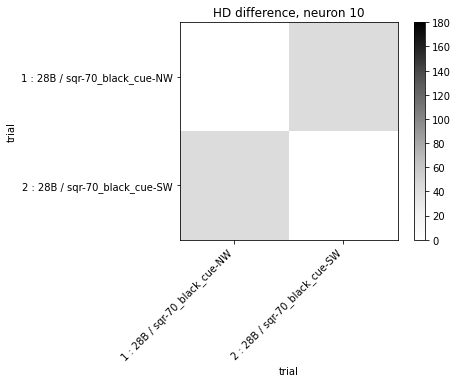

In [30]:
angle_diffs_all = []

for N, (n, ishdcell, hd_angles) in enumerate(zip(cg.neuron_list, hd_cells_, hd_angles_all)):
    if not ishdcell:
        continue
    
    # print(N, n.name, hd_angles)
    
    angle_diffs = angle_diff_matrix(hd_angles)
    angle_diffs_all.append(angle_diffs)
    # print(angle_diffs)
    
    fig, ax = plt.subplots()
    res = plt.imshow(angle_diffs , cmap='Greys', interpolation='none' )
    cb = fig.colorbar(res,ax=ax)
    res.set_clim((0,180))
    plt.xlabel("trial")
    plt.ylabel("trial")

    plt.xticks(range(len(angle_diffs)), trial_labels , rotation=45, ha='right' ) # plt.gca().set_xticks
    plt.yticks(range(len(angle_diffs)), trial_labels)

    plt.title("HD difference, neuron {}".format(n.name))
    plt.show()
    

In [31]:
angle_diffs_mean = np.mean(angle_diffs_all,axis=0)
angle_diffs_std = np.std(angle_diffs_all,axis=0)

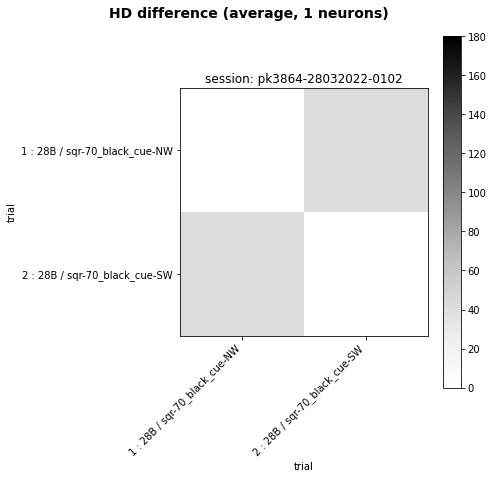

In [32]:
fig, ax = plt.subplots(figsize=(7,7))
res = plt.imshow(angle_diffs_mean , cmap='Greys', interpolation='none' )
cb = fig.colorbar(res,ax=ax)
res.set_clim((0,180))
plt.xlabel("trial")
plt.ylabel("trial")

plt.xticks(range(len(angle_diffs_mean)), trial_labels , rotation=45, ha='right' ) # plt.gca().set_xticks
plt.yticks(range(len(angle_diffs_mean)), trial_labels) 

plt.suptitle("HD difference (average, {} neurons)".format(len(angle_diffs_all)), fontsize=14, fontweight='bold')
plt.title("session: "+name)
plt.tight_layout()
plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'_HD-rotation.pdf')
plt.show()

In [33]:
for mean,std in zip(angle_diffs_mean[0,1:], angle_diffs_std[0,1:]):
    print(mean,std)

42.0146600761844 0.0


In [34]:
trial_labels

['1 : 28B / sqr-70_black_cue-NW', '2 : 28B / sqr-70_black_cue-SW']

In [35]:
data = np.array(angle_diffs_all)[:,0,1:] # all neurons, first row (compare first trial), with all but first trial
print(data.shape)

(1, 1)


In [36]:
compare_labels = [ trial_labels[0] + " -- " + t for t in trial_labels[1:] ]

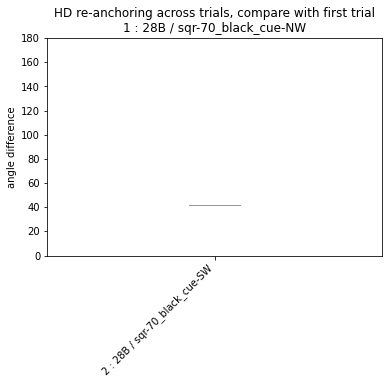

In [37]:
plt.boxplot(data)
plt.xticks(np.arange(1,len(trial_labels)), trial_labels[1:] , rotation=45, ha='right' )
plt.ylim((0,180))
plt.ylabel("angle difference")
plt.title("HD re-anchoring across trials, compare with first trial" + "\n" + trial_labels[0])
plt.show()

### **Grid analysis**

#### map correlation across trials

In [38]:
## Grid Cell detection, defined as := grid cell pattern in first & last trial
trial_1_and_2 = np.array(grid_cells_all)[:,0:2] # check for grid cells within first two trials
#trial_1_and_2 = np.array(grid_cells_all)[:,[0,-1]] # check for grid cells within first and last trials (reference baselines)

In [39]:
gridcell_any_ids = np.where(np.any(grid_cells_all,axis=1))[0]
gridcell_all_ids = np.where(np.all(grid_cells_all,axis=1))[0]
print("neurons with any trial showing grid cell ("+str(len(gridcell_any_ids))+"):", gridcell_any_ids)
print("neurons with all trial showing grid cell ("+str(len(gridcell_all_ids))+"):", gridcell_all_ids)

neurons with any trial showing grid cell (0): []
neurons with all trial showing grid cell (0): []


In [40]:
grid_cells_ = trial_1_and_2.all(axis=1)
print("Grid cells:", sum(grid_cells_), "out of", len(grid_cells_), "cells")

Grid cells: 0 out of 19 cells


In [41]:
grid_cells_ids = np.where(grid_cells_)[0]
print("grid cell neurons:", grid_cells_ids)
for g in grid_cells_ids:
    print("#",g, ",", "grid cell in trials:",grid_cells_all[g])

grid cell neurons: []


In [42]:
trials_in_environment_shape = [ [t,(shape,diam)] for t,(tn,su,en,(shape,diam,color,cue),ef,iv) in enumerate(session_trials) if t in trials_in_environment ]
print("trials_in_environment_shape:", trials_in_environment_shape)
shape=trials_in_environment_shape[0][1]
print("shape:",shape)
trials_in_environment_same_shape = [ t for t,s in trials_in_environment_shape if s==shape ]
print("trials_in_environment_same_shape:", trials_in_environment_same_shape)

trial_labels = [ str(t+1)+" : "+su+" / "+en for t,(tn,su,en,(shape,diam,color,cue),ef,iv) in enumerate(session_trials) if t in trials_in_environment_same_shape ]
print("trial_labels:", trial_labels)
trials_ids = [ i for i,t in enumerate(trials_in_environment) if t in trials_in_environment_same_shape ]
print("trials_ids:", trials_ids)

trials_in_environment_shape: [[0, ('square', 70.0)], [1, ('square', 70.0)]]
shape: ('square', 70.0)
trials_in_environment_same_shape: [0, 1]
trial_labels: ['1 : 28B / sqr-70_black_cue-NW', '2 : 28B / sqr-70_black_cue-SW']
trials_ids: [0, 1]


#### correlation across trials

In [43]:
grid_cell_ids = []

maps_correlation = [] # collect correlation of maps

for N, (n, isgridcell, firing_rate_maps) in enumerate(zip(cg.neuron_list, grid_cells_, firing_rate_maps_all)):
    if not isgridcell:
        continue
    
    map1 = firing_rate_maps[0]
    mcorr = []
    
    for t,map2 in zip(trials_in_environment, firing_rate_maps):
        if t not in trials_in_environment_same_shape:
            continue
        
        p = n.spatial_properties.map_crosscorrelation(map1=map1, map2=map2)
        mcorr.append(p)

    maps_correlation.append(mcorr)
    
    grid_cell_ids.append(N)

In [44]:
print("grid_cell_ids:", grid_cell_ids)

grid_cell_ids: []


In [45]:
plt.boxplot(np.array(maps_correlation)[:,1:])
plt.xticks(np.arange(1,len(trial_labels)), trial_labels[1:] , rotation=45, ha='right' )
plt.ylabel("map correlation")
plt.title("Grid cell remapping across trials, compare with first trial" + "\n" + trial_labels[0])
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

#### correlation across cells

In [ ]:
np.array(firing_rate_maps_all,dtype=object).shape

In [ ]:
from itertools import product

def pairs(a):
    return set(tuple(sorted(t)) for t in product(a,a) if t[0] != t[1])

In [ ]:
from scipy import signal
# corr = signal.correlate2d(map1, map2, boundary='symm', mode='same')
# corr = signal.correlate2d(map1, map2)

In [ ]:
def argmax2d(a):
    return np.unravel_index(np.argmax(a), a.shape)

In [ ]:
# trials_ids -> use all trials (no matter of shape)

In [ ]:
offset_vectors = []

for t in trials_ids:

    print("* trial",t)
    
    offset_vectors_trial = []

    for id1,id2 in pairs(grid_cell_ids):
        print("- grid cell pair: ",id1,id2)

    
        f1,f2 = np.array(firing_rate_maps_all,dtype=object)[[id1,id2],t]

        plt.imshow(f1)
        plt.title("firing map "+str(id1))
        plt.show()
        plt.imshow(f2)
        plt.title("firing map "+str(id2))
        plt.show()

        # c = signal.correlate2d(f1,f2, boundary='symm', mode='same')
        c = signal.correlate2d(f1,f2)
        print("correlate2d",c.shape)

        # print(np.min(c),np.max(c))
        # plt.imshow(c)
        # plt.show()

        midpoint = ((np.array(np.shape(c))-1)/2).astype(int)
        print("midpoint",midpoint)
        peak = np.array(argmax2d(c))
        print("peak",peak)
        offset = peak - midpoint

        print("offset",offset)
        
        offset_vectors_trial.append(offset)
        
        print("")
        
    
    for offset in offset_vectors_trial:
        plt.plot([0,offset[0]],[0,offset[1]])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("offset vectors for trial "+str(t))
    plt.show()
    
    offset_vectors.append(offset_vectors_trial)
    
    print("")

In [ ]:
np.array(offset_vectors).shape # = number of trials , number of grid cell pairs , 2 (2d vector)

##### **find best angle for the rotations**

In [ ]:
def rotate_by_degree(vec, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    return np.dot(R, vec)

In [ ]:
def error_func(deg, vectors_in,vectors_rotated):
    return np.sum([np.linalg.norm(vector2 - rotate_by_degree(vector1, deg)) for vector1,vector2 in zip(vectors_in,vectors_rotated) ])

In [ ]:
def error_func_vectorized(degs, *vectors):
    vectors_in,vectors_rotated = vectors
    return np.array([ error_func(deg, vectors_in,vectors_rotated) for deg in degs ])

In [ ]:
from scipy.optimize import minimize

def find_angle(vectors1,vectors2):
    ret = minimize(fun=error_func_vectorized, x0=90.1, bounds=[(0,360)], args=(vectors1,vectors2))
    return ret.x[0]

In [ ]:
# demonstration
vectors1 = np.array([[1,0],[0,1]])
vectors2 = np.array([[0,1],[-1,0]])
angle = find_angle(vectors1,vectors2)
print("angle",angle)

##### **do it for the trial data**

In [ ]:
# for n trials you have n-1 transitions

for vectors1,vectors2 in zip(offset_vectors[:-1],offset_vectors[1:]):
    print("vectors1:",vectors1)
    print("vectors2:",vectors2)
    deg = find_angle(vectors1,vectors2)
    print("angle: ",deg)
    print("")

In [ ]:
trial_rots = [ [ find_angle(vectors1,vectors2) for vectors2 in offset_vectors ] for vectors1 in offset_vectors ]

In [ ]:
trial_rots

In [ ]:
fig, ax = plt.subplots()
res = plt.imshow(trial_rots , cmap='Greys', interpolation='none' )
cb = fig.colorbar(res,ax=ax)
res.set_clim((0,360))
plt.xlabel("trial")
plt.ylabel("trial")

plt.xticks(range(len(trial_labels)), trial_labels , rotation=45, ha='right' )
plt.yticks(range(len(trial_labels)), trial_labels) 

plt.title("Grid cells' grid pattern rotation")
plt.show()

#### hexagon rotation

In [ ]:
hex_rot_all = []

for N, (n, isgridcell, grid_rotations) in enumerate(zip(cg.neuron_list, grid_cells_, grid_rotations_all)):
    if not isgridcell:
        continue
        
    print("N,n ",N,n.name)
    print("grid_rotations", grid_rotations)
    
    grid_rotations_deg = np.array(grid_rotations)*180/np.pi
    
    grid_rot_diffs = angle_diff_matrix(grid_rotations_deg, 60)
    print(grid_rot_diffs.shape, grid_rot_diffs)
    
    # plt.imshow(grid_rot_diffs)
    # plt.colorbar()
    # plt.show()
    
    fig, ax = plt.subplots()
    res = plt.imshow(grid_rot_diffs , cmap='Greys', interpolation='none' )
    cb = fig.colorbar(res,ax=ax)
    res.set_clim((0,30))
    plt.suptitle("Hexagon Rotation")
    plt.title("neuron {}".format(n.name))
    plt.show()

    
    hex_rot_all.append(grid_rot_diffs)
    # angle_diff(hexrot1,hexrot2, 60)

In [ ]:
hex_rot_mean = np.nanmean(hex_rot_all,axis=0)
print(hex_rot_mean)

In [ ]:
fig, ax = plt.subplots()
res = plt.imshow(hex_rot_mean , cmap='Greys', interpolation='none' )
cb = fig.colorbar(res,ax=ax)
res.set_clim((0,30))
plt.xlabel("trial")
plt.ylabel("trial")

plt.xticks(range(len(hex_rot_mean)), trial_labels_all , rotation=45, ha='right' ) # plt.gca().set_xticks
plt.yticks(range(len(hex_rot_mean)), trial_labels_all) 

plt.title("hexagonal mean grid rotation ({} neurons)".format(len(hex_rot_mean)))
plt.suptitle("session: "+name, fontsize=14, fontweight='bold')
plt.show()